In [127]:
#Importing all the tools
#API_extraction
import os
from dotenv import load_dotenv
import json
import requests
load_dotenv()
from IPython.display import display, Image
import re
import math
import pymongo
from pymongo import MongoClient
import itertools
import time


In [128]:
#Extracting pull request info from API(Not sure how to navigate through pages)
#All of them or only the closed ones??????

def requestGitHub (n=1, token=os.getenv("apikey"),queryParams={}):
    
    baseUrl='https://api.github.com'
    endpoint = f'/repos/ironhack-datalabs/datamad0820/pulls?page={n}&q=state%3Aall'

    url = baseUrl+endpoint

    headers = {
        "Authorization": f"token {token}"}

    res = requests.get(url, headers=headers)
    
    response = res.json()
    
    if res.status_code != 200:
        raise ValueError(f'Invalid github api call: {data["message"]}')
    
    return response


In [129]:
data = requestGitHub()

In [130]:
'''data[0]'''

'data[0]'

In [131]:
'''display(data[0]['user'])
''''''display(data[0]['body'])'''

"display(data[0]['user'])\ndisplay(data[0]['body'])"

In [132]:
x=11

print(re.search(r'[lab-].*\]',data[x]['title']).group().split(']')[0])

print(data[x]['user']['login'])

print(re.search(r"\] ([A-Za-z0-9-]+ [A-Za-z0-9-]+)", data[x]['title']).group(1))

if data[x]['assignee']['login'] == None:
    print('not assigned yet')
else:
    print(data[x]['assignee']['login'])

print(data[x]['created_at'].replace('T',' ').replace('Z',''))

if data[x]['closed_at'] == None:
    print('Not closed yet')
else:
    print(data[x]['closed_at'].replace('T',' ').replace('Z',''))

IndexError: list index out of range

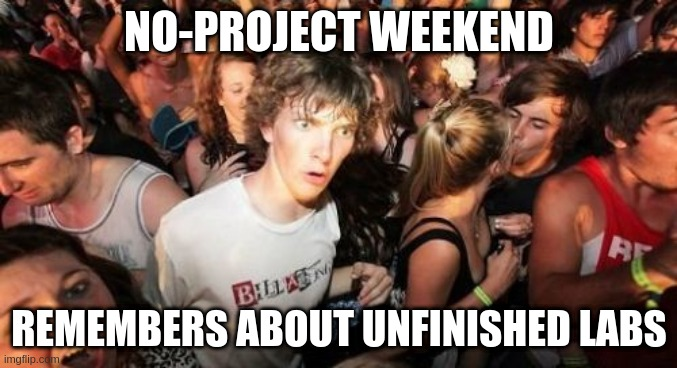

In [133]:
display(Image('https://user-images.githubusercontent.com/68472164/93796393-12fc0e00-fc3b-11ea-8abc-ce360f97083f.png'))

# API EXTRACTION

In [134]:

def getRequests(endpoint, token=os.getenv("apikey"), query_params={}):

    baseUrl = "https://api.github.com"
    url = f"{baseUrl}{endpoint}"

    headers = {
        "Authorization": f"token {token}"
    }

    res = requests.get(url, params=query_params, headers=headers)

    data = res.json()

    if res.status_code != 200:
        raise ValueError(f'Invalid github api call: {data["message"]}')

    return data

In [135]:
sample1 = getRequests("/repos/ironhack-datalabs/datamad0820/pulls",query_params={'state': 'all', 'page' : 1, "per_page":1})

In [136]:
def extractWantedData(data):

    """Create a dictionary with the selected information received from the github api"""
    dictionary=[]
    for x in range(0,len(data)):
        try:
            name={'number':data[x]['number'],
            'title':re.match('\[(.*?)\]',data[x]['title'],re.IGNORECASE).group(1).replace('-',' '),
            'user':data[x]['user']['login'],
            'state':data[x]['state'],
            'created_at':data[x]['created_at'],
            'updated_at':data[x]['updated_at'],
            'closed_at':data[x]['closed_at'],
            'TA':data[x]['assignee']['login'],
            'html_url':data[x]['html_url'],
            'meme':'no'
            }
            dictionary.append(name)
    
        except:
            name={'number':data[x]['number'],
            'title':re.match('\[(.*?)\]',data[x-1]['title'],re.IGNORECASE).group(1).replace('-',' '),
            'user':data[x]['user']['login'],
            'state':data[x]['state'],
            'created_at':data[x]['created_at'],
            'updated_at':data[x]['updated_at'],
            'closed_at':data[x]['closed_at'],
            'TA':'none',
            'html_url':data[x]['html_url'],
            'meme':'no'
            }
            dictionary.append(name)
            
    return dictionary

In [137]:
npages = getRequests("/repos/ironhack-datalabs/datamad0820/pulls",query_params={'state': 'all', 'page' : 1, "per_page":100})[0]['number']

def getDataDict(npages):
    """Get the information from all the github issues pages from a selected repository"""
    pulls = []
    for i in range(1, math.ceil(npages/100) + 1):
        pulls.append(extractWantedData(getRequests("/repos/ironhack-datalabs/datamad0820/pulls",query_params={'state': 'all', 'page' : i, "per_page":100})))
    clean_data = list(itertools.chain.from_iterable(pulls))
    return clean_data


In [138]:
list_pulls = getDataDict(npages)

In [139]:
len(list_pulls)

518

In [140]:
type(list_pulls)

list

In [141]:
type(list_pulls[0])

dict

In [142]:
#Importing tools
#MongoDB
from pymongo import MongoClient

In [143]:
PORT = os.getenv('PORT')
DBURL = os.getenv('DBURL')

In [144]:
def Import_to_mongoDB(lista):
    """Upload the info extractred from github to mongodb"""
    client = MongoClient(port=27017)
    db=client.RankingDB
    for x in range(0,len(lista)):
        result = db.pulls.insert_one(lista[x])
    print(f'finished creating {len(lista)} pull requests')

In [145]:
Import_to_mongoDB(list_pulls)

finished creating 518 pull requests


In [146]:
PORT


'3000'

In [147]:
#sample1

#  WEBSCRAPING

In [148]:
import requests
import bs4
import re
import itertools
import time
import json


In [149]:
url  = 'https://github.com/ironhack-datalabs/datamad0820/network/members'

In [150]:
def getUsers(url):
    res = requests.get(url)
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    users = re.findall("@\w+\S\w\w*", str(soup))
    users = list(set(users))
    unwanted_users =['@ferrero-felipe', '@WHYTEWYLL', '@agalvezcorell', '@github', '@ironhack-datalabs']
    for i in unwanted_users:
        if i in users:
            users.remove(i)
    dic_users = { i : users[i] for i in range(0, len(users) ) }
    dic_users = {v: k for k, v in dic_users.items()}
    return dic_users

In [151]:
def split_dict(input_dict, chunks=28):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list

In [152]:
s_users = split_dict(getUsers(url))
s_users

[{'@Davidlazarog': 0},
 {'@Alvere': 1},
 {'@rfminguez': 2},
 {'@gontzalm': 3},
 {'@MigeruDono': 4},
 {'@AnaMA96': 5},
 {'@laura290': 6},
 {'@charliesket': 7},
 {'@Gon41': 8},
 {'@Diegon8': 9},
 {'@IreneLopezLujan': 10},
 {'@FDELTA': 11},
 {'@jmena23': 12},
 {'@PaulaNuno': 13},
 {'@silviaherf': 14},
 {'@VanessaMacC': 15},
 {'@CarlosSanzDGP': 16},
 {'@Jav1-Mart1nez': 17},
 {'@Daniel-GarciaGarcia': 18},
 {'@miguelgimenezgimenez': 19},
 {'@KevsDe': 20},
 {'@Joycelili': 21},
 {'@marta-zavala': 22},
 {'@RobotKidz': 23},
 {'@bmedm': 24},
 {'@grundius1': 25},
 {'@jorge-alamillos': 26},
 {'@DiegoCaulonga': 27}]

In [153]:
def import_users(lista):
    client = MongoClient(port=27017)
    db=client.RankingDB
    for x in range(0,len(lista)):
        result = db.users.insert_one(lista[x])
    print(f'finished adding {len(lista)} users')
    

In [154]:
import_users(s_users)

finished adding 28 users


In [155]:
def get_meme(url):
    """Web scraping for github comment page to extract the instructor comment meme"""
    res = requests.get(url)
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    try:
        img = soup.select('.edit-comment-hide')[1].select('img')[0].get('src')
        return img
    except:
        return None

# Lista_Memes

In [156]:
def get_meme(url):
    """Web scraping for github comment page to extract the instructor comment meme"""
    res = requests.get(url)
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    try:
        img = soup.select('.edit-comment-hide')[1].select('img')[0].get('src')
        return img
    except:
        return None
    

In [157]:

def get_github_users(url):
    """Web scraping for github comment page to get the students github user"""
    teachers = ['@ferrero-felipe', '@WHYTEWYLL', '@agalvezcorell', '@github','@github.com']
    res = requests.get(url)
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    user_github = re.findall("@\w+\S\w\w*", str(soup))
    user_github = list(set(user_github))
    for teacher in teachers:
        if teacher in user_github:
            user_github.remove(teacher)

    return user_github


In [158]:
'''def meme_lst(lista):
    """Insert the meme url and students github users from the comment poge to the dictionary with the info extracted from the github api"""
    for x in range(0,(len(lista))):
        print(x)
        lista[x]['users'] = get_github_users(lista[x]['html_url'])
        lista[x]['meme'] = get_meme(lista[x]['html_url'])
        time.sleep(3)'''

In [160]:
memes = meme_lst(list_pulls)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [171]:
memes

In [168]:
def getmemeDict(npages):
    """Get the information from all the github issues pages from a selected repository"""
    memes = []
    for i in range(1, math.ceil(npages/100) + 1):
        memes.append(get_meme(getRequests("/repos/ironhack-datalabs/datamad0820/pulls",query_params={'state': 'all', 'page' : i, "per_page":100})))
    clean_data = list(itertools.chain.from_iterable(memes))
    return clean_data

In [169]:
getmemeDict(npages)

InvalidSchema: No connection adapters were found for '[{'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541', 'id': 490428782, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDkwNDI4Nzgy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541', 'number': 541, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Lab rehecho! Os paso la pull \r\n![image](https://user-images.githubusercontent.com/68472164/93796393-12fc0e00-fc3b-11ea-8abc-ce360f97083f.png)\r\n', 'created_at': '2020-09-21T16:45:52Z', 'updated_at': '2020-09-23T23:38:02Z', 'closed_at': '2020-09-23T23:38:01Z', 'merged_at': None, 'merge_commit_sha': 'da33f152b84a2630a63f37df735065298961014f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3f554b2a0d5c81a74bcb271d40fde2f0737d66b5', 'head': {'label': 'Diegon8:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '3f554b2a0d5c81a74bcb271d40fde2f0737d66b5', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/541'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3f554b2a0d5c81a74bcb271d40fde2f0737d66b5'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540', 'id': 489229497, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg5MjI5NDk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540', 'number': 540, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Tableau :hankey: ', 'created_at': '2020-09-18T10:35:42Z', 'updated_at': '2020-09-21T16:01:22Z', 'closed_at': '2020-09-21T16:01:22Z', 'merged_at': None, 'merge_commit_sha': 'e788eca91581c809c379ea44d193738943b7309d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23d6e3197795248c1e61c74ec4082826811e0987', 'head': {'label': 'gontzalm:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '23d6e3197795248c1e61c74ec4082826811e0987', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/540'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23d6e3197795248c1e61c74ec4082826811e0987'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539', 'id': 489105621, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg5MTA1NjIx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539', 'number': 539, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Irene Lopez Luján', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Debo el apartado 10 y 1 1, me he quedado con  las ganas, pero ayer el dia no daba más.', 'created_at': '2020-09-18T06:25:41Z', 'updated_at': '2020-09-21T15:54:26Z', 'closed_at': '2020-09-21T15:54:26Z', 'merged_at': None, 'merge_commit_sha': '1ee917da527614e1562da40efa4973080510f07d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1e0450c58eec9400f40289f9ec6c5b07744b73f2', 'head': {'label': 'IreneLopezLujan:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '1e0450c58eec9400f40289f9ec6c5b07744b73f2', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/539'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1e0450c58eec9400f40289f9ec6c5b07744b73f2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538', 'id': 488940035, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4OTQwMDM1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538', 'number': 538, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': '![image](https://user-images.githubusercontent.com/68472164/93529702-a8965580-f93c-11ea-81f7-38042ccc85e3.png)\r\n', 'created_at': '2020-09-17T21:24:25Z', 'updated_at': '2020-09-24T21:36:08Z', 'closed_at': '2020-09-24T21:36:08Z', 'merged_at': None, 'merge_commit_sha': '1f11e89369cf1af9ce5f4a869d918cf1c2e3b872', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c61057a53e7e3bd6f03fd03f1c5b1549a7411635', 'head': {'label': 'Diegon8:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'c61057a53e7e3bd6f03fd03f1c5b1549a7411635', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/538'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c61057a53e7e3bd6f03fd03f1c5b1549a7411635'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537', 'id': 488866104, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODY2MTA0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537', 'number': 537, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Laura Larrad y Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Chicos,\r\n\r\nOs facilitamos archivo con URL al dashboard de Tableau\r\n\r\n\r\nMuchas gracias,\r\nLaura y Paula', 'created_at': '2020-09-17T18:56:47Z', 'updated_at': '2020-09-21T15:47:18Z', 'closed_at': '2020-09-21T15:47:18Z', 'merged_at': None, 'merge_commit_sha': 'fe42f5fd2e872903ee1b286168c67a67691e0965', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fad91fb45b32716c04c1a595dc29104e2c5c8c56', 'head': {'label': 'PaulaNuno:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'fad91fb45b32716c04c1a595dc29104e2c5c8c56', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/537'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fad91fb45b32716c04c1a595dc29104e2c5c8c56'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536', 'id': 488861544, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODYxNTQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536', 'number': 536, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nAdjunto el txt con las urls de los ejercicios de fúrgol americano y el de países del bonus.\r\n\r\nUn saludo.', 'created_at': '2020-09-17T18:47:19Z', 'updated_at': '2020-09-21T15:42:29Z', 'closed_at': '2020-09-21T15:42:28Z', 'merged_at': None, 'merge_commit_sha': '9877d6c56c259a84733117f5d3d5604f616173e9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/2b023523eb4a110a2dbb0e6e4a179f810813577a', 'head': {'label': 'rfminguez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '2b023523eb4a110a2dbb0e6e4a179f810813577a', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/536'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/2b023523eb4a110a2dbb0e6e4a179f810813577a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535', 'id': 488834099, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODM0MDk5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535', 'number': 535, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Tableau es un pepino! los readme.... jajajaja 🤣 \r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93508792-20ee1e00-f91f-11ea-9e61-7ccd36cfe880.png)\r\n\r\n', 'created_at': '2020-09-17T17:51:22Z', 'updated_at': '2020-09-24T21:26:20Z', 'closed_at': '2020-09-24T21:26:19Z', 'merged_at': None, 'merge_commit_sha': 'c60365899df0e65100e4960f72a1694517a522ba', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0df00f1cd6adef9ec065c4d14d5c8267143788ea', 'head': {'label': 'Jav1-Mart1nez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '0df00f1cd6adef9ec065c4d14d5c8267143788ea', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/535'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0df00f1cd6adef9ec065c4d14d5c8267143788ea'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534', 'id': 488825910, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODI1OTEw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534', 'number': 534, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T17:34:37Z', 'updated_at': '2020-09-24T21:23:29Z', 'closed_at': '2020-09-24T21:23:29Z', 'merged_at': None, 'merge_commit_sha': '73f82c00388ba2cc570e747e71c7caaca3b20ed6', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/7d906cdd1f667c126860341f806b45f4539a2421', 'head': {'label': 'Daniel-GarciaGarcia:tableau', 'ref': 'tableau', 'sha': '7d906cdd1f667c126860341f806b45f4539a2421', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/534'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/7d906cdd1f667c126860341f806b45f4539a2421'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533', 'id': 488811766, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODExNzY2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533', 'number': 533, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hello!! He guardado el URL en un VSC llamado lab.txt dentro del disco del lab. Por si acaso os cuesta encontrarlo lo dejo aqui: https://public.tableau.com/profile/diego.caulonga#!/vizhome/Lab_16003557133250/NumberofGames?publish=yes\r\n\r\nMe ha parecido muy divertido Tableau, me ha gustado mucho.', 'created_at': '2020-09-17T17:07:26Z', 'updated_at': '2020-09-21T15:33:51Z', 'closed_at': '2020-09-21T15:33:50Z', 'merged_at': None, 'merge_commit_sha': '800a3a8d2d0f8eb331cc26e649f75fc0a2400bfc', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/59bf4314a382c3a776a13e20df4b4db314ff55d2', 'head': {'label': 'DiegoCaulonga:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '59bf4314a382c3a776a13e20df4b4db314ff55d2', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/533'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/59bf4314a382c3a776a13e20df4b4db314ff55d2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532', 'id': 488810192, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODEwMTky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532', 'number': 532, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas, dejo por aquí el txt con los links al Tableau público. \r\n\r\nMuy guapo este lab, se pueden hacer visualizaciones potentes con este juguetito, me ha gustado.\r\n\r\n![image](https://user-images.githubusercontent.com/61025562/93503847-8dadec00-f910-11ea-9bfe-df9994649816.png)\r\n\r\n\r\n', 'created_at': '2020-09-17T17:04:17Z', 'updated_at': '2020-09-21T15:27:52Z', 'closed_at': '2020-09-21T15:27:51Z', 'merged_at': None, 'merge_commit_sha': 'a0c099d0083064013ce347f88da40a977ca42a3e', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a71f7b3298389711dd11f074383d2a273da6a56', 'head': {'label': 'jmena23:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '4a71f7b3298389711dd11f074383d2a273da6a56', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/532'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a71f7b3298389711dd11f074383d2a273da6a56'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531', 'id': 488807161, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODA3MTYx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531', 'number': 531, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': 'no se si estan bien subidos, avisadme si veis algun error', 'created_at': '2020-09-17T16:58:28Z', 'updated_at': '2020-09-21T15:22:47Z', 'closed_at': '2020-09-21T15:22:42Z', 'merged_at': None, 'merge_commit_sha': '1590e2b7427d6722c1a3732ccf9dd8d29e3d17fa', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/edc8f58a309aac91e9c807dd57b559a9780e9cc6', 'head': {'label': 'grundius1:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'edc8f58a309aac91e9c807dd57b559a9780e9cc6', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/531'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/edc8f58a309aac91e9c807dd57b559a9780e9cc6'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530', 'id': 488805904, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODA1OTA0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530', 'number': 530, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:56:03Z', 'updated_at': '2020-09-21T15:15:03Z', 'closed_at': '2020-09-21T15:15:03Z', 'merged_at': None, 'merge_commit_sha': '0879389023131b539efddff05394a4a956fd4fa9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b3392e83c0b7d0b697d3ca42e62900290e01b8e9', 'head': {'label': 'marta-zavala:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'b3392e83c0b7d0b697d3ca42e62900290e01b8e9', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/530'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b3392e83c0b7d0b697d3ca42e62900290e01b8e9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529', 'id': 488802666, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODAyNjY2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529', 'number': 529, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Jorge Alamillos Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Ejercicios Tableuuuuuuu!!! + Bonus!!\r\n\r\n\r\n![](https://memegenerator.net/img/instances/82461075.jpg)\r\n', 'created_at': '2020-09-17T16:49:51Z', 'updated_at': '2020-09-24T20:55:34Z', 'closed_at': '2020-09-24T20:55:34Z', 'merged_at': None, 'merge_commit_sha': '2362c27e07de24797700e1346b75f4f511cadfa1', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/752e0fb8ab7640463ed7789592885dd8a240175f', 'head': {'label': 'Joycelili:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '752e0fb8ab7640463ed7789592885dd8a240175f', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/529'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/752e0fb8ab7640463ed7789592885dd8a240175f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528', 'id': 488796386, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk2Mzg2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528', 'number': 528, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'En el bonus, al hacer el mapa de densidad de población no se marcaba la diferencia de colores, es decir, salia todo del mismo color. He decidido poner población nada mas que si que se ve la diferencia. Me ha encantado este lab!!\r\n\r\n\r\n![image](https://user-images.githubusercontent.com/68757683/93500799-dcf61b80-f914-11ea-9684-a0ccf1fdbac1.png)\r\n', 'created_at': '2020-09-17T16:37:47Z', 'updated_at': '2020-09-24T20:33:26Z', 'closed_at': '2020-09-24T20:33:25Z', 'merged_at': None, 'merge_commit_sha': '6b00aab3a46826b9f21bf23097ffe140b7089321', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513', 'head': {'label': 'charliesket:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/528'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527', 'id': 488796274, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk2Mjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527', 'number': 527, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:37:35Z', 'updated_at': '2020-09-24T15:48:26Z', 'closed_at': '2020-09-24T15:48:26Z', 'merged_at': None, 'merge_commit_sha': 'c494ea6fab7f1ccf73b8bb6bdce26a4a58f13927', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/afdf5ae08c6f48a70203e15d836397793f5da165', 'head': {'label': 'KevsDe:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'afdf5ae08c6f48a70203e15d836397793f5da165', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/527'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/afdf5ae08c6f48a70203e15d836397793f5da165'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526', 'id': 488794081, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk0MDgx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526', 'number': 526, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:33:40Z', 'updated_at': '2020-09-21T15:11:57Z', 'closed_at': '2020-09-21T15:11:56Z', 'merged_at': None, 'merge_commit_sha': '8a341d5b0affb6032b08204ebfc0e7848028a414', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/68d7c10e140b460d26dadad13664fe7a386bc301', 'head': {'label': 'bmedm:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '68d7c10e140b460d26dadad13664fe7a386bc301', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/526'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/68d7c10e140b460d26dadad13664fe7a386bc301'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525', 'id': 488793348, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NzkzMzQ4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525', 'number': 525, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me encanta este lab! Y además, mañana es viernes!', 'created_at': '2020-09-17T16:32:21Z', 'updated_at': '2020-09-24T09:44:17Z', 'closed_at': '2020-09-24T09:44:17Z', 'merged_at': None, 'merge_commit_sha': 'd9efe735d053b817d1cac5b75cc9ec3d365917a2', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c0cc2c99a7148081c013c6294613581ce5e344ea', 'head': {'label': 'VanessaMacC:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'c0cc2c99a7148081c013c6294613581ce5e344ea', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/525'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c0cc2c99a7148081c013c6294613581ce5e344ea'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524', 'id': 488789594, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzg5NTk0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524', 'number': 524, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:25:27Z', 'updated_at': '2020-09-21T15:07:59Z', 'closed_at': '2020-09-21T15:07:49Z', 'merged_at': None, 'merge_commit_sha': '63f72219d6e5c6b324e3fcbf47d4a197570bf254', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3384b0831fb36a06801ee2c01660518fccb12959', 'head': {'label': 'miguelgimenezgimenez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '3384b0831fb36a06801ee2c01660518fccb12959', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/524'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3384b0831fb36a06801ee2c01660518fccb12959'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523', 'id': 488778616, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzc4NjE2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523', 'number': 523, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Silvia Hernández y Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '@silviaherf\r\n\r\nNO nos gusta NADA esto.🤡', 'created_at': '2020-09-17T16:08:34Z', 'updated_at': '2020-09-24T09:13:07Z', 'closed_at': '2020-09-24T09:13:07Z', 'merged_at': None, 'merge_commit_sha': '19c51d8fdf2f53fd2ceb8f114263b326a44a2253', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1164e4ec26e7c320b86072346b71e2209aa088f9', 'head': {'label': 'AnaMA96:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '1164e4ec26e7c320b86072346b71e2209aa088f9', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/523'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1164e4ec26e7c320b86072346b71e2209aa088f9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522', 'id': 488768941, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NzY4OTQx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522', 'number': 522, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] David Lazaro y Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T15:54:23Z', 'updated_at': '2020-09-24T08:16:43Z', 'closed_at': '2020-09-24T08:16:42Z', 'merged_at': None, 'merge_commit_sha': 'e2dab70452a9c5bac8127b517813bca4596e7f4c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/103e2fc0eb0d108795d2206b2c01b2cef89de8e2', 'head': {'label': 'FDELTA:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '103e2fc0eb0d108795d2206b2c01b2cef89de8e2', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/522'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/103e2fc0eb0d108795d2206b2c01b2cef89de8e2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521', 'id': 488491610, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDkxNjEw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521', 'number': 521, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Se me había olvidado hacer la PR!!!!! Sorry!', 'created_at': '2020-09-17T08:16:25Z', 'updated_at': '2020-09-23T23:34:28Z', 'closed_at': '2020-09-23T23:34:28Z', 'merged_at': None, 'merge_commit_sha': 'f476ed89b0fef9721743233194e125be5f2907f0', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/350f02f1e0f717b5ae738e4cb1db659d344fe2d0', 'head': {'label': 'VanessaMacC:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '350f02f1e0f717b5ae738e4cb1db659d344fe2d0', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/521'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/350f02f1e0f717b5ae738e4cb1db659d344fe2d0'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520', 'id': 488471439, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDcxNDM5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520', 'number': 520, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, chicos,\r\n\r\nNo me ha ido muy bien en este lab.\r\nOs paso el challenge-1 con la resolución sin mucho éxito en la parte de arriba del archivo :)\r\n\r\nMuchas gracias por vuestra ayuda,\r\nPaua', 'created_at': '2020-09-17T07:38:21Z', 'updated_at': '2020-09-21T14:39:18Z', 'closed_at': '2020-09-21T14:39:18Z', 'merged_at': None, 'merge_commit_sha': 'd9a74864b00ed812dc50456c97d29f73a0f9fcd5', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf', 'head': {'label': 'PaulaNuno:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/520'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519', 'id': 488460940, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDYwOTQw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519', 'number': 519, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Irene Lopez', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T07:16:50Z', 'updated_at': '2020-09-21T14:33:46Z', 'closed_at': '2020-09-21T14:33:46Z', 'merged_at': None, 'merge_commit_sha': '35f4b314f579c330e916015b3bb93496f9bf8433', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/cf898c8c65b9eb69577ff783a09619d6a881601a', 'head': {'label': 'IreneLopezLujan:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'cf898c8c65b9eb69577ff783a09619d6a881601a', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/519'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/cf898c8c65b9eb69577ff783a09619d6a881601a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518', 'id': 488244362, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjQ0MzYy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518', 'number': 518, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nDejo la solución a los challenges 1, 2  y 3. El bonus no lo he conseguido avanzar (la programación recursiva se me hace bola).\r\n\r\nUn saludo.', 'created_at': '2020-09-16T21:04:18Z', 'updated_at': '2020-09-21T14:28:17Z', 'closed_at': '2020-09-21T14:28:16Z', 'merged_at': None, 'merge_commit_sha': '735dbfc9d34b1e1a1e2c4993069f07feb44262f7', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/970f8012d86fa878df90b851d178558342698bf7', 'head': {'label': 'rfminguez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '970f8012d86fa878df90b851d178558342698bf7', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/518'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/970f8012d86fa878df90b851d178558342698bf7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517', 'id': 488235313, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjM1MzEz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517', 'number': 517, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola Amanda prometo hacer el bonus el finde semana, no me daba la cabeza para más...Me cuesta muchísimo hacer el código más eficiente .\r\nDel challenge-1, no me gusta nada como he hecho lo de los "if .... and" por favor, ilumíname!!! 😢\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93390547-27708d00-f86e-11ea-9421-b19d85139535.png)\r\n', 'created_at': '2020-09-16T20:44:31Z', 'updated_at': '2020-09-23T23:26:34Z', 'closed_at': '2020-09-23T23:26:34Z', 'merged_at': None, 'merge_commit_sha': '51828152139927e198baea7a6b138da5577cce90', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b6ba390b3c48b824b1a17a9eaad21fad89abe545', 'head': {'label': 'Jav1-Mart1nez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'b6ba390b3c48b824b1a17a9eaad21fad89abe545', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/517'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b6ba390b3c48b824b1a17a9eaad21fad89abe545'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516', 'id': 488229340, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjI5MzQw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516', 'number': 516, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T20:31:54Z', 'updated_at': '2020-09-24T18:52:33Z', 'closed_at': '2020-09-23T21:44:59Z', 'merged_at': None, 'merge_commit_sha': '26318c6a710b448504c73d3f83ba8d605f57f553', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/191509458cc0e1f5b2f3f6676c4869a3bd76b0c2', 'head': {'label': 'Daniel-GarciaGarcia:master', 'ref': 'master', 'sha': '191509458cc0e1f5b2f3f6676c4869a3bd76b0c2', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/516'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/191509458cc0e1f5b2f3f6676c4869a3bd76b0c2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515', 'id': 488229274, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjI5Mjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515', 'number': 515, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hecho', 'created_at': '2020-09-16T20:31:46Z', 'updated_at': '2020-09-23T11:24:05Z', 'closed_at': '2020-09-23T11:24:05Z', 'merged_at': None, 'merge_commit_sha': 'fee2ab30c37efe5e15cad2dc799ac9ba0c9d310f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/637f203ac21bc80f44beffc5943aaf2d1d5e3406', 'head': {'label': 'jorge-alamillos:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '637f203ac21bc80f44beffc5943aaf2d1d5e3406', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/515'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/637f203ac21bc80f44beffc5943aaf2d1d5e3406'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514', 'id': 488186525, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTg2NTI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514', 'number': 514, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Claramente le voy a tener que pegar un repaso este finde... Empiezo bien con el challenge 1 pero va de mal en peor, el bonus es que no se ni que hacer... \r\nLe he dado mil vueltas a cada uno y me estoy volviendo loco probando y fallando, he dejado comentarios en los challenges de como lo veo mas o menos.\r\n\r\n![image](https://user-images.githubusercontent.com/68757683/93371290-655fb800-f852-11ea-87ba-f79ad59c5a4a.png)\r\n', 'created_at': '2020-09-16T19:01:11Z', 'updated_at': '2020-09-23T10:24:16Z', 'closed_at': '2020-09-23T10:24:15Z', 'merged_at': None, 'merge_commit_sha': 'c932f23439c5d45a19b912e1171ee8351ef49909', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8b193832b1f990f61a05de7c352726d616bf32ab', 'head': {'label': 'charliesket:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '8b193832b1f990f61a05de7c352726d616bf32ab', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/514'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8b193832b1f990f61a05de7c352726d616bf32ab'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513', 'id': 488182496, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTgyNDk2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513', 'number': 513, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas tardes!!\r\nEl challenge-2 no he sabido como refactorizarlo,le he estado dando muchas vueltas y probando cosas pero no se me ocurria..El 1,y el 3 los he hecho,pero seguro que algo rusticos..\r\n\r\nUn saludo!!', 'created_at': '2020-09-16T18:53:22Z', 'updated_at': '2020-09-21T14:22:55Z', 'closed_at': '2020-09-21T14:22:55Z', 'merged_at': None, 'merge_commit_sha': 'fe851e90887f7733153618fc366abc541c843ebb', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/79cf1028961d2b182b81e4f171ce38636a1c3c95', 'head': {'label': 'laura290:lab-simplicity-efficiency', 'ref': 'lab-simplicity-efficiency', 'sha': '79cf1028961d2b182b81e4f171ce38636a1c3c95', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/513'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/79cf1028961d2b182b81e4f171ce38636a1c3c95'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512', 'id': 488180414, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTgwNDE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512', 'number': 512, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🤡', 'created_at': '2020-09-16T18:49:02Z', 'updated_at': '2020-09-23T09:43:47Z', 'closed_at': '2020-09-23T09:43:47Z', 'merged_at': None, 'merge_commit_sha': 'c71a7dc03c8665a0e7ff06a9f11ada5ce4c4c99f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4573b376e46fef446d5232e86bcee1a331c69eb4', 'head': {'label': 'AnaMA96:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '4573b376e46fef446d5232e86bcee1a331c69eb4', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/512'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4573b376e46fef446d5232e86bcee1a331c69eb4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511', 'id': 488159988, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTU5OTg4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511', 'number': 511, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'El Challenge 2 no lo he llegado a entenderlo bien. ', 'created_at': '2020-09-16T18:06:10Z', 'updated_at': '2020-09-21T14:14:10Z', 'closed_at': '2020-09-21T14:14:10Z', 'merged_at': None, 'merge_commit_sha': 'b8550588d839372122a8183413c160513d954180', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ae2a527146761c05d5ca8738dae2774ea380bfa4', 'head': {'label': 'DiegoCaulonga:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'ae2a527146761c05d5ca8738dae2774ea380bfa4', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/511'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ae2a527146761c05d5ca8738dae2774ea380bfa4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510', 'id': 488139537, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTM5NTM3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510', 'number': 510, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Holaa, el lab de hoy. \r\n\r\n**Va sin bonus, no se me ha ocurrido como mejorar lo que ya estaba en el código.', 'created_at': '2020-09-16T17:33:51Z', 'updated_at': '2020-09-21T14:00:32Z', 'closed_at': '2020-09-21T14:00:18Z', 'merged_at': None, 'merge_commit_sha': '7eb45c8d02e09a4d91e85401d8c3156371da5868', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef', 'head': {'label': 'jmena23:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/510'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509', 'id': 488123597, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTIzNTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509', 'number': 509, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T17:00:45Z', 'updated_at': '2020-09-21T13:29:37Z', 'closed_at': '2020-09-21T13:29:36Z', 'merged_at': None, 'merge_commit_sha': 'd087a71581c584d21fdaeb46ccb36622a18cb1e1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6bd5b0ed367b75ad4f8f8e94a9690e5476741e77', 'head': {'label': 'bmedm:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6bd5b0ed367b75ad4f8f8e94a9690e5476741e77', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/509'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6bd5b0ed367b75ad4f8f8e94a9690e5476741e77'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508', 'id': 488119223, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTE5MjIz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508', 'number': 508, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': 'El bonus creo que no está bien!! Pero lo he intentado :smile: \r\n\r\nSaludissssssssssssss', 'created_at': '2020-09-16T16:52:08Z', 'updated_at': '2020-09-21T11:53:47Z', 'closed_at': '2020-09-21T11:53:47Z', 'merged_at': None, 'merge_commit_sha': '90c242ef9df976291c49cce4f28c033ffe67f1fd', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0166c5030db05b67dbe3a45d9aab51998eedfc6b', 'head': {'label': 'silviaherf:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '0166c5030db05b67dbe3a45d9aab51998eedfc6b', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/508'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0166c5030db05b67dbe3a45d9aab51998eedfc6b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507', 'id': 488118152, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTE4MTUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507', 'number': 507, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T16:50:10Z', 'updated_at': '2020-09-23T07:57:05Z', 'closed_at': '2020-09-23T07:57:05Z', 'merged_at': None, 'merge_commit_sha': '15c0dfa4cda69e7f9333769b8f6ee0304d131baf', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6ad29d17f5c49984a14c9880bb31dd3d15dba313', 'head': {'label': 'KevsDe:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6ad29d17f5c49984a14c9880bb31dd3d15dba313', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/507'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6ad29d17f5c49984a14c9880bb31dd3d15dba313'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506', 'id': 488078928, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDc4OTI4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506', 'number': 506, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:42:02Z', 'updated_at': '2020-09-21T11:41:07Z', 'closed_at': '2020-09-21T11:41:07Z', 'merged_at': None, 'merge_commit_sha': '922430ed782a25a71fee88a13bb26538843072ea', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/206e48c87b063f142af2795361893f22c9e5b948', 'head': {'label': 'grundius1:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '206e48c87b063f142af2795361893f22c9e5b948', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/506'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/206e48c87b063f142af2795361893f22c9e5b948'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505', 'id': 488078572, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDc4NTcy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505', 'number': 505, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] David Lazaro', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Travesura realizada!', 'created_at': '2020-09-16T15:41:27Z', 'updated_at': '2020-09-23T07:54:31Z', 'closed_at': '2020-09-23T07:54:30Z', 'merged_at': None, 'merge_commit_sha': '62e514b341871ae7937b27ff44e087fba13cdf76', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8735320e0f4fe98c3a997d1f1ae1ab99669633d9', 'head': {'label': 'Davidlazarog:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '8735320e0f4fe98c3a997d1f1ae1ab99669633d9', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166981, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5ODE=', 'name': 'datamad0820', 'full_name': 'Davidlazarog/datamad0820', 'private': False, 'owner': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Davidlazarog/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Davidlazarog/datamad0820', 'forks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/deployments', 'created_at': '2020-08-17T11:52:52Z', 'updated_at': '2020-09-10T14:46:44Z', 'pushed_at': '2020-09-16T15:40:41Z', 'git_url': 'git://github.com/Davidlazarog/datamad0820.git', 'ssh_url': 'git@github.com:Davidlazarog/datamad0820.git', 'clone_url': 'https://github.com/Davidlazarog/datamad0820.git', 'svn_url': 'https://github.com/Davidlazarog/datamad0820', 'homepage': None, 'size': 163391, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/505'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8735320e0f4fe98c3a997d1f1ae1ab99669633d9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504', 'id': 488066160, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDY2MTYw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504', 'number': 504, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:21:35Z', 'updated_at': '2020-09-18T11:28:00Z', 'closed_at': '2020-09-18T11:28:00Z', 'merged_at': None, 'merge_commit_sha': '0d632232557227ba63e817164f63e09858215535', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58fe593c8fb350f29aacabc6aa257b3a22ebfe1a', 'head': {'label': 'marta-zavala:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '58fe593c8fb350f29aacabc6aa257b3a22ebfe1a', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/504'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58fe593c8fb350f29aacabc6aa257b3a22ebfe1a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503', 'id': 488053385, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDUzMzg1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503', 'number': 503, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:02:03Z', 'updated_at': '2020-09-18T11:13:25Z', 'closed_at': '2020-09-18T11:13:11Z', 'merged_at': None, 'merge_commit_sha': '4f3cdf069f6b0be10f99fc9967170ac02d995f29', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e40babd09f9eae93be8ed69bf33e90e7074e477b', 'head': {'label': 'miguelgimenezgimenez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'e40babd09f9eae93be8ed69bf33e90e7074e477b', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/503'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e40babd09f9eae93be8ed69bf33e90e7074e477b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502', 'id': 488051053, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDUxMDUz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502', 'number': 502, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T14:58:36Z', 'updated_at': '2020-09-18T09:32:53Z', 'closed_at': '2020-09-18T09:32:45Z', 'merged_at': None, 'merge_commit_sha': '37918bca1f0b7b54f04bb11d589165e4c9d86df9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6f53e2b0bf91a2a4f27fefa1943344c673056333', 'head': {'label': 'gontzalm:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6f53e2b0bf91a2a4f27fefa1943344c673056333', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/502'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6f53e2b0bf91a2a4f27fefa1943344c673056333'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501', 'id': 488033884, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDMzODg0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501', 'number': 501, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T14:33:25Z', 'updated_at': '2020-09-18T10:20:06Z', 'closed_at': '2020-09-18T10:20:05Z', 'merged_at': None, 'merge_commit_sha': '006159c95cea098e54ae6aff99cee99c8157ac9c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca496be0e797503888f0b9cee6d498a2c0ce987b', 'head': {'label': 'Joycelili:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'ca496be0e797503888f0b9cee6d498a2c0ce987b', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/501'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca496be0e797503888f0b9cee6d498a2c0ce987b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500', 'id': 487800177, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3ODAwMTc3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500', 'number': 500, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Irene Lopez', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T07:47:51Z', 'updated_at': '2020-09-18T08:53:16Z', 'closed_at': '2020-09-18T08:52:30Z', 'merged_at': None, 'merge_commit_sha': 'cf5f38431d667c5badec34bc3ecad2be38807232', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/496de4ae9d572e662b33527aaf07d798d5b4f554', 'head': {'label': 'IreneLopezLujan:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '496de4ae9d572e662b33527aaf07d798d5b4f554', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/500'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/496de4ae9d572e662b33527aaf07d798d5b4f554'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499', 'id': 487577444, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NTc3NDQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499', 'number': 499, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T21:03:26Z', 'updated_at': '2020-09-17T22:49:44Z', 'closed_at': '2020-09-17T22:49:44Z', 'merged_at': None, 'merge_commit_sha': '74ad73957704d1a21f7b0558d73e9c8b770a2d0e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e01443dae79ad7105e97c0253bbdbd95c6e77be9', 'head': {'label': 'Daniel-GarciaGarcia:mongoquery', 'ref': 'mongoquery', 'sha': 'e01443dae79ad7105e97c0253bbdbd95c6e77be9', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/499'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e01443dae79ad7105e97c0253bbdbd95c6e77be9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498', 'id': 487510522, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NTEwNTIy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498', 'number': 498, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Ohhhh que gusto con Mongo\r\n\r\n![mongod](https://user-images.githubusercontent.com/66042132/93255229-e3ac5380-f799-11ea-8710-bace53d84864.jpeg)\r\n', 'created_at': '2020-09-15T19:23:07Z', 'updated_at': '2020-09-17T22:46:25Z', 'closed_at': '2020-09-17T22:46:25Z', 'merged_at': None, 'merge_commit_sha': '3916c92a12d642207af24d15321c2f91b68f7f03', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58ec8ca281cc95122c37ee3fc668d77e01ac9ca9', 'head': {'label': 'Joycelili:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '58ec8ca281cc95122c37ee3fc668d77e01ac9ca9', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/498'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58ec8ca281cc95122c37ee3fc668d77e01ac9ca9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497', 'id': 487462833, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDYyODMz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497', 'number': 497, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, Amanda y Felipe,\r\n\r\nHago pull con el lab de hoy.\r\nMe gustó mucho :)\r\n\r\nMuchas gracias!\r\nPaula', 'created_at': '2020-09-15T18:01:32Z', 'updated_at': '2020-09-18T08:50:20Z', 'closed_at': '2020-09-18T08:50:20Z', 'merged_at': None, 'merge_commit_sha': 'b560d2d54776123d07b1856d615aee4bf6d2d65d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d2467706ad1b6aca8c2672c0f7e43af5c2e27e2a', 'head': {'label': 'PaulaNuno:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'd2467706ad1b6aca8c2672c0f7e43af5c2e27e2a', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/497'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d2467706ad1b6aca8c2672c0f7e43af5c2e27e2a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496', 'id': 487459276, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDU5Mjc2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496', 'number': 496, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hecho! el ultimo no me salía! Gracias!', 'created_at': '2020-09-15T17:54:05Z', 'updated_at': '2020-09-17T22:42:43Z', 'closed_at': '2020-09-17T22:42:43Z', 'merged_at': None, 'merge_commit_sha': 'febe6e4183cdf256c38372adb90e4e6ed323e59f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca7ac3e7fb9109b239fb464fa7a7a86086f96309', 'head': {'label': 'jorge-alamillos:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'ca7ac3e7fb9109b239fb464fa7a7a86086f96309', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/496'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca7ac3e7fb9109b239fb464fa7a7a86086f96309'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495', 'id': 487443967, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDQzOTY3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495', 'number': 495, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, dejo por aquí el lab de hoy. \r\n\r\n** El ejercicio 20 no he sabido sacarlo. ¿Cómo se resolvía?', 'created_at': '2020-09-15T17:23:30Z', 'updated_at': '2020-09-18T08:48:29Z', 'closed_at': '2020-09-18T08:48:29Z', 'merged_at': None, 'merge_commit_sha': '2ed1e26070549ed7317fb40abea7a2c7b03cd2da', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/907859905fcf4c29daf7b949d822c57806221326', 'head': {'label': 'jmena23:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '907859905fcf4c29daf7b949d822c57806221326', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/495'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/907859905fcf4c29daf7b949d822c57806221326'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494', 'id': 487435452, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDM1NDUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494', 'number': 494, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'looking for the meme...', 'created_at': '2020-09-15T17:07:03Z', 'updated_at': '2020-09-18T08:18:42Z', 'closed_at': '2020-09-17T22:41:10Z', 'merged_at': None, 'merge_commit_sha': '90c8f32036c6d2779e4f37406547c002f1c1b8c7', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2635e8d9d79ca9812a4491e42abcfadf0bc5646', 'head': {'label': 'Diegon8:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'b2635e8d9d79ca9812a4491e42abcfadf0bc5646', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/494'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2635e8d9d79ca9812a4491e42abcfadf0bc5646'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493', 'id': 487432116, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDMyMTE2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493', 'number': 493, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mongo me gusta!\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93241462-a6d66180-f785-11ea-8222-900437cbfe34.png)\r\n', 'created_at': '2020-09-15T17:00:25Z', 'updated_at': '2020-09-17T22:39:35Z', 'closed_at': '2020-09-17T22:39:34Z', 'merged_at': None, 'merge_commit_sha': '82eeddcdced499039bb9ae0ffb9f3909e07b657d', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/42c189187f32d266f85123068879272ea46b39da', 'head': {'label': 'Jav1-Mart1nez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '42c189187f32d266f85123068879272ea46b39da', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/493'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/42c189187f32d266f85123068879272ea46b39da'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492', 'id': 487431929, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDMxOTI5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492', 'number': 492, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo]Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T17:00:01Z', 'updated_at': '2020-09-18T08:42:58Z', 'closed_at': '2020-09-18T08:42:49Z', 'merged_at': None, 'merge_commit_sha': 'da7cef6e2064e27b8f15d2c00170be6e72324d9a', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64c89354330da60aba80f6a0fd6cf50580ffaebd', 'head': {'label': 'DiegoCaulonga:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '64c89354330da60aba80f6a0fd6cf50580ffaebd', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/492'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64c89354330da60aba80f6a0fd6cf50580ffaebd'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491', 'id': 487429581, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDI5NTgx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491', 'number': 491, 'state': 'closed', 'locked': False, 'title': '[lab advance querying mongo] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Aquí os paso el ejercicio,aunque algunos no he sabido hacerlos', 'created_at': '2020-09-15T16:55:20Z', 'updated_at': '2020-09-18T08:40:23Z', 'closed_at': '2020-09-18T08:40:22Z', 'merged_at': None, 'merge_commit_sha': '7667603dc9eaa28e4adabf8cbc3b672bf796ceb7', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c061b6b72b8fb72db2d218b903fb3140896ea8d4', 'head': {'label': 'laura290:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'c061b6b72b8fb72db2d218b903fb3140896ea8d4', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/491'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c061b6b72b8fb72db2d218b903fb3140896ea8d4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490', 'id': 487418263, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDE4MjYz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490', 'number': 490, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Por fin un lab que acabo!! \r\n', 'created_at': '2020-09-15T16:33:40Z', 'updated_at': '2020-09-17T22:37:24Z', 'closed_at': '2020-09-17T22:37:24Z', 'merged_at': None, 'merge_commit_sha': 'a6e9a566eba5c68bba4f2bc024924ccd9eb5f17f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c3e6b7545881c0fee5df88105bcba7dfeb29b68f', 'head': {'label': 'VanessaMacC:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'c3e6b7545881c0fee5df88105bcba7dfeb29b68f', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/490'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c3e6b7545881c0fee5df88105bcba7dfeb29b68f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489', 'id': 487406692, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDA2Njky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489', 'number': 489, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': 'MongoDB mola, tiene un diseño bastante menos arcáico que MySQL jejeje.', 'created_at': '2020-09-15T16:12:45Z', 'updated_at': '2020-09-18T08:04:24Z', 'closed_at': '2020-09-18T08:04:24Z', 'merged_at': None, 'merge_commit_sha': '9b2dac6c1ced01f4deec94b422d31d1fc675279c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a46a149986cc12378d76db205d97aec74e602159', 'head': {'label': 'gontzalm:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'a46a149986cc12378d76db205d97aec74e602159', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/489'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a46a149986cc12378d76db205d97aec74e602159'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488', 'id': 487403674, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAzNjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488', 'number': 488, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Carlos González-Gordon Luque', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me ha encantado este lab!!!\r\n![image](https://user-images.githubusercontent.com/68757683/93235773-4abc0f00-f77e-11ea-9af8-d9542305812a.png)\r\n', 'created_at': '2020-09-15T16:07:30Z', 'updated_at': '2020-09-17T22:36:07Z', 'closed_at': '2020-09-17T22:36:06Z', 'merged_at': None, 'merge_commit_sha': '68224902c9c048a80e2bf588dde54b3a8619e51e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/178e9bc06688f758849c5b534ec5b50a623597ec', 'head': {'label': 'charliesket:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '178e9bc06688f758849c5b534ec5b50a623597ec', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/488'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/178e9bc06688f758849c5b534ec5b50a623597ec'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487', 'id': 487403608, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAzNjA4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487', 'number': 487, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:07:24Z', 'updated_at': '2020-09-16T15:37:22Z', 'closed_at': '2020-09-16T15:37:12Z', 'merged_at': None, 'merge_commit_sha': '1a6b2ee2231bf1159977f5518f20d1ae1b4ede3c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd', 'head': {'label': 'silviaherf:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'd04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/487'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486', 'id': 487402912, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAyOTEy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486', 'number': 486, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:06:07Z', 'updated_at': '2020-09-17T22:34:33Z', 'closed_at': '2020-09-17T22:34:33Z', 'merged_at': None, 'merge_commit_sha': 'd6296f1458d6b0615c8209359225a049ae8f262d', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a543a0e9c214155bc8e60570e1f612fcdd9f74c7', 'head': {'label': 'KevsDe:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'a543a0e9c214155bc8e60570e1f612fcdd9f74c7', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/486'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a543a0e9c214155bc8e60570e1f612fcdd9f74c7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485', 'id': 487400152, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAwMTUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485', 'number': 485, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:01:36Z', 'updated_at': '2020-09-16T15:34:26Z', 'closed_at': '2020-09-16T15:34:25Z', 'merged_at': None, 'merge_commit_sha': '257646bd2c223780c941321217f42ba52d659a38', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0a0f2225d710dc1238415caa4145250e699c941e', 'head': {'label': 'marta-zavala:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '0a0f2225d710dc1238415caa4145250e699c941e', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/485'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0a0f2225d710dc1238415caa4145250e699c941e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484', 'id': 487399572, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzk5NTcy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484', 'number': 484, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nDejo las consultas a mongodb que he hecho en el fichero EJERCICIOS.md\r\n\r\nUn saludo.', 'created_at': '2020-09-15T16:00:39Z', 'updated_at': '2020-09-16T15:33:17Z', 'closed_at': '2020-09-16T15:33:17Z', 'merged_at': None, 'merge_commit_sha': '6e0b4ce6ee5e30379862189e4231c2e8e8f49dbf', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/083480fc1d54a9793794294793e393f1b0d4820a', 'head': {'label': 'rfminguez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '083480fc1d54a9793794294793e393f1b0d4820a', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/484'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/083480fc1d54a9793794294793e393f1b0d4820a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483', 'id': 487397121, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzk3MTIx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483', 'number': 483, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:56:39Z', 'updated_at': '2020-09-16T15:29:05Z', 'closed_at': '2020-09-16T15:26:14Z', 'merged_at': None, 'merge_commit_sha': '08877c6694b60e488363dd569cee2404d7601d07', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/39f825fda0fd1bc087cd4599daadd56b341e5c1e', 'head': {'label': 'miguelgimenezgimenez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '39f825fda0fd1bc087cd4599daadd56b341e5c1e', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/483'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/39f825fda0fd1bc087cd4599daadd56b341e5c1e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482', 'id': 487387659, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzg3NjU5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482', 'number': 482, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🇲🇳 ', 'created_at': '2020-09-15T15:41:20Z', 'updated_at': '2020-09-17T22:30:13Z', 'closed_at': '2020-09-17T22:30:13Z', 'merged_at': None, 'merge_commit_sha': 'f492133c8e0a27d703434c6b94d0c751c88d8aa4', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/798ddd670ed0742be6dd9680c0cecdca97050623', 'head': {'label': 'AnaMA96:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '798ddd670ed0742be6dd9680c0cecdca97050623', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/482'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/798ddd670ed0742be6dd9680c0cecdca97050623'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481', 'id': 487387405, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzg3NDA1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481', 'number': 481, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:40:55Z', 'updated_at': '2020-09-16T15:23:40Z', 'closed_at': '2020-09-16T15:23:39Z', 'merged_at': None, 'merge_commit_sha': '5bafee08f183a401bba27adafe9257e9255772da', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/71786af2908fc36ee6976cd541ac5c23421e29ab', 'head': {'label': 'bmedm:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '71786af2908fc36ee6976cd541ac5c23421e29ab', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/481'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/71786af2908fc36ee6976cd541ac5c23421e29ab'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480', 'id': 487382931, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3MzgyOTMx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480', 'number': 480, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] David Lazaro', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Travesura realizada!! ', 'created_at': '2020-09-15T15:33:53Z', 'updated_at': '2020-09-17T22:24:50Z', 'closed_at': '2020-09-17T22:24:49Z', 'merged_at': None, 'merge_commit_sha': '903680b17b93a29d9d2c62f6339fcd2a068764f9', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1bed38c76e74348df4dd18a2e22251051afc6163', 'head': {'label': 'Davidlazarog:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '1bed38c76e74348df4dd18a2e22251051afc6163', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166981, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5ODE=', 'name': 'datamad0820', 'full_name': 'Davidlazarog/datamad0820', 'private': False, 'owner': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Davidlazarog/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Davidlazarog/datamad0820', 'forks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/deployments', 'created_at': '2020-08-17T11:52:52Z', 'updated_at': '2020-09-10T14:46:44Z', 'pushed_at': '2020-09-16T15:40:41Z', 'git_url': 'git://github.com/Davidlazarog/datamad0820.git', 'ssh_url': 'git@github.com:Davidlazarog/datamad0820.git', 'clone_url': 'https://github.com/Davidlazarog/datamad0820.git', 'svn_url': 'https://github.com/Davidlazarog/datamad0820', 'homepage': None, 'size': 163391, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/480'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1bed38c76e74348df4dd18a2e22251051afc6163'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479', 'id': 487378891, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzc4ODkx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479', 'number': 479, 'state': 'closed', 'locked': False, 'title': '[lab-advance-queryng-mongo] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:27:41Z', 'updated_at': '2020-09-16T15:19:24Z', 'closed_at': '2020-09-16T15:19:23Z', 'merged_at': None, 'merge_commit_sha': '7408b5925369b6c7e8614150a2e82cd41acaece1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/09826c91d9e509510091f44b7c78f9fc5c2351a3', 'head': {'label': 'grundius1:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '09826c91d9e509510091f44b7c78f9fc5c2351a3', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/479'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/09826c91d9e509510091f44b7c78f9fc5c2351a3'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478', 'id': 487376824, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzc2ODI0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478', 'number': 478, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-querying-mongo] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': 'terminao', 'created_at': '2020-09-15T15:24:26Z', 'updated_at': '2020-09-17T22:23:02Z', 'closed_at': '2020-09-17T22:23:02Z', 'merged_at': None, 'merge_commit_sha': '901831491479fe03605c3ae476e9376bf1ab8388', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/63aff0b21cca1b04fd277a9a85129243541fd188', 'head': {'label': 'FDELTA:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '63aff0b21cca1b04fd277a9a85129243541fd188', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/478'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/63aff0b21cca1b04fd277a9a85129243541fd188'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454', 'id': 484809664, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0ODA5NjY0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454', 'number': 454, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T08:31:53Z', 'updated_at': '2020-09-16T09:56:49Z', 'closed_at': '2020-09-16T09:56:49Z', 'merged_at': None, 'merge_commit_sha': '8d2fa17cd69e1deb97b1a833077351c2d4e5f703', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/9c67a4696f5b8462aff8cbb3aa95d118e7c392aa', 'head': {'label': 'FDELTA:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '9c67a4696f5b8462aff8cbb3aa95d118e7c392aa', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/454'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/9c67a4696f5b8462aff8cbb3aa95d118e7c392aa'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453', 'id': 484808356, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0ODA4MzU2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453', 'number': 453, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T08:30:27Z', 'updated_at': '2020-09-16T15:01:06Z', 'closed_at': '2020-09-16T15:01:06Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fbc90c273cabb0dca76edc775ed232ecd3a56f1b', 'head': {'label': 'FDELTA:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': 'fbc90c273cabb0dca76edc775ed232ecd3a56f1b', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/453'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fbc90c273cabb0dca76edc775ed232ecd3a56f1b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452', 'id': 484713225, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzEzMjI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452', 'number': 452, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Sin terminar.\r\n', 'created_at': '2020-09-11T06:47:18Z', 'updated_at': '2020-09-17T15:28:34Z', 'closed_at': '2020-09-17T15:28:34Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/56ed2486290fbf68ae0452c6e643b63be0e1f7c2', 'head': {'label': 'Joycelili:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '56ed2486290fbf68ae0452c6e643b63be0e1f7c2', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/452'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/56ed2486290fbf68ae0452c6e643b63be0e1f7c2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451', 'id': 484710528, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzEwNTI4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451', 'number': 451, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'No me da tiempo a buscar meme!!!!!!', 'created_at': '2020-09-11T06:44:00Z', 'updated_at': '2020-09-16T09:46:27Z', 'closed_at': '2020-09-16T09:46:26Z', 'merged_at': None, 'merge_commit_sha': 'ac3a38229ff546f78cee01b001702b55eb82a8e4', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/10dc055da649b595b973c91869fc978d772262a7', 'head': {'label': 'Diegon8:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '10dc055da649b595b973c91869fc978d772262a7', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/451'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/10dc055da649b595b973c91869fc978d772262a7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450', 'id': 484708597, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzA4NTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450', 'number': 450, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': '![image](https://user-images.githubusercontent.com/68472164/92876587-98491c80-f40a-11ea-94a1-ad000918f145.png)\r\n', 'created_at': '2020-09-11T06:41:36Z', 'updated_at': '2020-09-16T14:58:24Z', 'closed_at': '2020-09-16T14:55:16Z', 'merged_at': None, 'merge_commit_sha': '1e68bcab6aefe1c29add286939b73bdae2c90927', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1a551b942059cb8b74108990209854dab076c521', 'head': {'label': 'Diegon8:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '1a551b942059cb8b74108990209854dab076c521', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/450'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1a551b942059cb8b74108990209854dab076c521'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449', 'id': 484693700, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NjkzNzAw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449', 'number': 449, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Irene Lopez ', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T06:22:31Z', 'updated_at': '2020-09-17T22:08:24Z', 'closed_at': '2020-09-17T22:08:23Z', 'merged_at': None, 'merge_commit_sha': '06588fd2510fdc402c6a68234642278b639e76b7', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4e5b428288bd236d39e11e67bf07a677cd972d50', 'head': {'label': 'IreneLopezLujan:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '4e5b428288bd236d39e11e67bf07a677cd972d50', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/449'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4e5b428288bd236d39e11e67bf07a677cd972d50'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448', 'id': 484692420, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NjkyNDIw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448', 'number': 448, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Irene Lopez ', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T06:20:48Z', 'updated_at': '2020-09-17T15:26:21Z', 'closed_at': '2020-09-17T15:26:21Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e00315f7825c1e4a2a5dae1a2a184947c8c5e80c', 'head': {'label': 'IreneLopezLujan:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'e00315f7825c1e4a2a5dae1a2a184947c8c5e80c', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/448'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e00315f7825c1e4a2a5dae1a2a184947c8c5e80c'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447', 'id': 484689301, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Njg5MzAx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447', 'number': 447, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '<a href="https://imgflip.com/i/4ekrls"><img src="https://i.imgflip.com/4ekrls.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>', 'created_at': '2020-09-11T06:16:26Z', 'updated_at': '2020-09-16T14:58:57Z', 'closed_at': '2020-09-16T12:06:43Z', 'merged_at': None, 'merge_commit_sha': '5bab3c0c168cef4d0760a045666dec44ff924008', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5efc73bf36917b0eba15e6337de0efc2d8699bd4', 'head': {'label': 'miguelgimenezgimenez:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '5efc73bf36917b0eba15e6337de0efc2d8699bd4', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/447'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5efc73bf36917b0eba15e6337de0efc2d8699bd4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446', 'id': 484420814, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDIwODE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446', 'number': 446, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api-data] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hello. No llevo nada bien el tema de las APIs. Mañana voy a ir al parque de bolas por la tarde, igual pido al TA que pueda que me ayude a hacer este ejercicio paso a paso entendiéndolo todo. ', 'created_at': '2020-09-10T23:05:11Z', 'updated_at': '2020-09-16T09:40:06Z', 'closed_at': '2020-09-16T09:39:33Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f1b2a5c96d48363adf98ba0b4064cd63fa31033', 'head': {'label': 'DiegoCaulonga:Parsing-API-Data', 'ref': 'Parsing-API-Data', 'sha': '8f1b2a5c96d48363adf98ba0b4064cd63fa31033', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/446'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f1b2a5c96d48363adf98ba0b4064cd63fa31033'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445', 'id': 484411651, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDExNjUx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445', 'number': 445, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': 'lo siento', 'created_at': '2020-09-10T22:52:36Z', 'updated_at': '2020-09-17T14:10:58Z', 'closed_at': '2020-09-17T14:10:58Z', 'merged_at': None, 'merge_commit_sha': '2438c8e7fe1d2a6d0774deacfa827680a2eb607e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f06020de0b2c1b30e62fcdb45328aa9366db577', 'head': {'label': 'Daniel-GarciaGarcia:wapi', 'ref': 'wapi', 'sha': '8f06020de0b2c1b30e62fcdb45328aa9366db577', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/445'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f06020de0b2c1b30e62fcdb45328aa9366db577'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444', 'id': 484406580, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDA2NTgw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444', 'number': 444, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas]Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'En el ejercicio del In[6] no estaba muy seguro de lo que peíia, así que he hecho un poco lo que he interpretado.\r\nLa función del Challenge 2 creo que esta bien creada pero me dice que no puedo iterar floats. H e intentado convertir las i en int(i) y alguna cosa más pero nada. No sé. El resto no podia hacerlo sin ese.\r\nDel challenge 3 me tengo que repasar bastante mas el Regex y cómo aplicarlo a Pandas, y el tema de sustituir mayúscula por vocal no he sabido hacerlo.\r\n\r\n', 'created_at': '2020-09-10T22:45:05Z', 'updated_at': '2020-09-16T11:35:38Z', 'closed_at': '2020-09-16T11:35:38Z', 'merged_at': None, 'merge_commit_sha': 'e9fefb818dc1ca95ee7f38ad628eed8a40a5b79b', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8e2f861d4708f095fdf5fef6dfb733a24e1d380c', 'head': {'label': 'DiegoCaulonga:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '8e2f861d4708f095fdf5fef6dfb733a24e1d380c', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/444'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8e2f861d4708f095fdf5fef6dfb733a24e1d380c'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443', 'id': 484403691, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDAzNjkx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443', 'number': 443, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T22:40:35Z', 'updated_at': '2020-09-17T22:01:58Z', 'closed_at': '2020-09-17T22:01:58Z', 'merged_at': None, 'merge_commit_sha': '708190d9d81a359e4ae0219b010334fb9cfdc903', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/059e68c9d087907b194026847bef952bd8f32c54', 'head': {'label': 'marta-zavala:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '059e68c9d087907b194026847bef952bd8f32c54', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/443'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/059e68c9d087907b194026847bef952bd8f32c54'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442', 'id': 484403232, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDAzMjMy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442', 'number': 442, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T22:39:50Z', 'updated_at': '2020-09-17T14:09:20Z', 'closed_at': '2020-09-17T14:09:19Z', 'merged_at': None, 'merge_commit_sha': '41e3531fa038e74a46d3721d81e953f446e763d0', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0995f56b33e5f59e23f0ac06b65a3888b8841dc5', 'head': {'label': 'marta-zavala:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '0995f56b33e5f59e23f0ac06b65a3888b8841dc5', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/442'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0995f56b33e5f59e23f0ac06b65a3888b8841dc5'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441', 'id': 484345983, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzQ1OTgz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441', 'number': 441, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nMando el ejercicio de parsing de la página de zalando. Espero no haberla liado con la actualización de Felipe y el posterior baile de commits.\r\n\r\nUn saludo.', 'created_at': '2020-09-10T21:26:01Z', 'updated_at': '2020-09-17T11:35:16Z', 'closed_at': '2020-09-17T11:34:45Z', 'merged_at': None, 'merge_commit_sha': '0b7344e1f905a9a4e2a3f7f953856edf1817eb46', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5191db8492d238d3ba9b823f8bb70f1b26573b6e', 'head': {'label': 'rfminguez:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '5191db8492d238d3ba9b823f8bb70f1b26573b6e', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/441'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5191db8492d238d3ba9b823f8bb70f1b26573b6e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440', 'id': 484333414, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzMzNDE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440', 'number': 440, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T21:11:27Z', 'updated_at': '2020-09-16T09:26:04Z', 'closed_at': '2020-09-16T09:26:03Z', 'merged_at': None, 'merge_commit_sha': '12d3b595a0c5ad3a28e1b6d071b5650589d8ba83', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce', 'head': {'label': 'jorge-alamillos:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/440'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439', 'id': 484310934, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzEwOTM0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439', 'number': 439, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mañana es viernes!! Segunda parte', 'created_at': '2020-09-10T20:44:16Z', 'updated_at': '2020-09-16T09:23:41Z', 'closed_at': '2020-09-16T09:23:28Z', 'merged_at': None, 'merge_commit_sha': '967963a3e23602784b91daf160459b11c04df53e', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f', 'head': {'label': 'VanessaMacC:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/439'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438', 'id': 484299636, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk5NjM2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438', 'number': 438, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Lab completo! he dejado algún comentario con alguna duda!', 'created_at': '2020-09-10T20:29:54Z', 'updated_at': '2020-09-16T09:17:52Z', 'closed_at': '2020-09-16T09:17:52Z', 'merged_at': None, 'merge_commit_sha': '3e7429067422a51ab8df3f5723775c6eeeb3b2d0', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ab4136194eccac10230c1e11c518195d5dde5715', 'head': {'label': 'Jav1-Mart1nez:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'ab4136194eccac10230c1e11c518195d5dde5715', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/438'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ab4136194eccac10230c1e11c518195d5dde5715'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437', 'id': 484297637, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk3NjM3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437', 'number': 437, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T20:27:33Z', 'updated_at': '2020-09-17T11:22:47Z', 'closed_at': '2020-09-17T11:22:47Z', 'merged_at': None, 'merge_commit_sha': '850ebdf09357c49dcffcd842b45ac927336037b5', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/872a706e40c65195fac458a90f759447be4cae73', 'head': {'label': 'AnaMA96:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '872a706e40c65195fac458a90f759447be4cae73', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/437'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/872a706e40c65195fac458a90f759447be4cae73'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436', 'id': 484296268, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk2MjY4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436', 'number': 436, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🐼🐻🦊🐰🐯🦁🐱🐶🐹', 'created_at': '2020-09-10T20:25:57Z', 'updated_at': '2020-09-17T20:45:08Z', 'closed_at': '2020-09-17T20:45:08Z', 'merged_at': None, 'merge_commit_sha': '980225b4562284d523895efe4d145633a5b86004', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1dcc07bc555273ce3769373bc8857a6a81d42e68', 'head': {'label': 'AnaMA96:advanced-topics-with-pandas', 'ref': 'advanced-topics-with-pandas', 'sha': '1dcc07bc555273ce3769373bc8857a6a81d42e68', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/436'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1dcc07bc555273ce3769373bc8857a6a81d42e68'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435', 'id': 484267944, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjY3OTQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435', 'number': 435, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Vanessa Machuca ', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mañana es viernes!!! ', 'created_at': '2020-09-10T19:52:32Z', 'updated_at': '2020-09-16T10:54:51Z', 'closed_at': '2020-09-16T10:54:51Z', 'merged_at': None, 'merge_commit_sha': '0d0dc1f72d8f5b204a21df966c8c0864d5db488c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17b09f19e257c9c707bda627c2fb45d88e0f43c7', 'head': {'label': 'VanessaMacC:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '17b09f19e257c9c707bda627c2fb45d88e0f43c7', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/435'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17b09f19e257c9c707bda627c2fb45d88e0f43c7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434', 'id': 484225125, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjI1MTI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434', 'number': 434, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas..\r\nEl ejercicio esta a medias..', 'created_at': '2020-09-10T19:03:56Z', 'updated_at': '2020-09-16T10:34:34Z', 'closed_at': '2020-09-16T10:34:33Z', 'merged_at': None, 'merge_commit_sha': '3dc944752c534b6e5ed977f9e5414f5f54960330', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17893112abe89f754ce6be043e58320fec4a076f', 'head': {'label': 'laura290:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '17893112abe89f754ce6be043e58320fec4a076f', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/434'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17893112abe89f754ce6be043e58320fec4a076f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433', 'id': 484222326, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjIyMzI2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433', 'number': 433, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': 'ueee cómo mola!!!! Cuando sale medio bien... :smile: ', 'created_at': '2020-09-10T19:00:54Z', 'updated_at': '2020-09-16T08:49:38Z', 'closed_at': '2020-09-16T08:49:23Z', 'merged_at': None, 'merge_commit_sha': '7622f05cb096243baac2ccb90506d3c3eb4609bc', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/675853988723e2d4b8713ceca2d872dab7c11855', 'head': {'label': 'silviaherf:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '675853988723e2d4b8713ceca2d872dab7c11855', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/433'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/675853988723e2d4b8713ceca2d872dab7c11855'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432', 'id': 484207548, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA3NTQ4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432', 'number': 432, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:46:57Z', 'updated_at': '2020-09-16T16:55:01Z', 'closed_at': '2020-09-16T16:55:00Z', 'merged_at': None, 'merge_commit_sha': '856d253bde53ab2129276865bdb4a3a68a3f549f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2435484de908acb833a4a1c479cc794ddb1aa72', 'head': {'label': 'bmedm:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'b2435484de908acb833a4a1c479cc794ddb1aa72', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/432'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2435484de908acb833a4a1c479cc794ddb1aa72'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431', 'id': 484206197, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA2MTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431', 'number': 431, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:45:50Z', 'updated_at': '2020-09-17T22:00:05Z', 'closed_at': '2020-09-17T22:00:05Z', 'merged_at': None, 'merge_commit_sha': '2241892c1d9d9c6140f695640f5385fe92063d0c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/456d52266268f4162bbd900bf1264f7b32d01c58', 'head': {'label': 'bmedm:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '456d52266268f4162bbd900bf1264f7b32d01c58', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/431'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/456d52266268f4162bbd900bf1264f7b32d01c58'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430', 'id': 484204061, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA0MDYx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430', 'number': 430, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, dejo por aquí el ejercicio de la api de zalando. No se si he aprendido mucho ya que prácticamente era copiar el ejercicio guía.\r\n\r\n** El número de páginas lo limité a 200 ya que nunca me terminaba las 600 y pico que eran.', 'created_at': '2020-09-10T18:43:55Z', 'updated_at': '2020-09-16T10:53:24Z', 'closed_at': '2020-09-16T10:53:24Z', 'merged_at': None, 'merge_commit_sha': '4f3b84a01ce440abac96e68626dc950cd955a2a5', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a87885b42db9599cfae11eb6ddb71ae17ff36e2e', 'head': {'label': 'jmena23:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'a87885b42db9599cfae11eb6ddb71ae17ff36e2e', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/430'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a87885b42db9599cfae11eb6ddb71ae17ff36e2e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429', 'id': 484186602, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTg2NjAy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429', 'number': 429, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Chicos,\r\n\r\nUnos panditas por aquí :)\r\n\r\nMuchas gracias por vuestra ayuda,\r\nPaula', 'created_at': '2020-09-10T18:24:59Z', 'updated_at': '2020-09-17T21:56:00Z', 'closed_at': '2020-09-17T21:56:00Z', 'merged_at': None, 'merge_commit_sha': '4fa53ae010b3a4556511132e5b0c0cbf3308958a', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/656d186695550b5ff7456b5875b81a975464d9fc', 'head': {'label': 'PaulaNuno:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '656d186695550b5ff7456b5875b81a975464d9fc', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/429'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/656d186695550b5ff7456b5875b81a975464d9fc'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428', 'id': 484183243, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTgzMjQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428', 'number': 428, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\nHe dejado algunas preguntas dentro del jupyter.\r\n\r\n¡Gracias!!!!', 'created_at': '2020-09-10T18:21:10Z', 'updated_at': '2020-09-16T10:29:11Z', 'closed_at': '2020-09-16T10:29:11Z', 'merged_at': None, 'merge_commit_sha': 'a55035a72de8e8e4b56bcb4ac736a511f9841a22', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/702d6ce50ce068e7419af7abad3f8e1d8c26b98f', 'head': {'label': 'KevsDe:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '702d6ce50ce068e7419af7abad3f8e1d8c26b98f', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/428'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/702d6ce50ce068e7419af7abad3f8e1d8c26b98f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427', 'id': 484181295, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTgxMjk1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427', 'number': 427, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:19:07Z', 'updated_at': '2020-09-16T08:46:47Z', 'closed_at': '2020-09-16T08:46:47Z', 'merged_at': None, 'merge_commit_sha': '6c133e05a8b114bf09dba8a210e9b278b06059eb', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f9f561025ea790bb1c32f41290dcd3d13b520ba4', 'head': {'label': 'KevsDe:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'f9f561025ea790bb1c32f41290dcd3d13b520ba4', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/427'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f9f561025ea790bb1c32f41290dcd3d13b520ba4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426', 'id': 484171639, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTcxNjM5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426', 'number': 426, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me gustaría ver mas en detalle el tema de los apis, porque es un poco complejo...', 'created_at': '2020-09-10T18:08:53Z', 'updated_at': '2020-09-16T10:43:27Z', 'closed_at': '2020-09-16T10:43:27Z', 'merged_at': None, 'merge_commit_sha': '4ec4d1c3c1c69fa792520f307c05ea97b8e4cc83', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c9f54fafeade3f307fea3a2507dd6f1e46b6994f', 'head': {'label': 'charliesket:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'c9f54fafeade3f307fea3a2507dd6f1e46b6994f', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/426'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c9f54fafeade3f307fea3a2507dd6f1e46b6994f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425', 'id': 484167943, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTY3OTQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425', 'number': 425, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas tardes!!\r\nNo me cargaron todas las páginas,me peto el ordena un par de veces..\r\n\r\nun saludo!!', 'created_at': '2020-09-10T18:06:29Z', 'updated_at': '2020-09-16T08:42:02Z', 'closed_at': '2020-09-16T08:41:55Z', 'merged_at': None, 'merge_commit_sha': 'af24c1d6defd37d8500528017f2e14432890e854', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a4c987849a488b0190fd22b0acebd55639854fe9', 'head': {'label': 'laura290:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'a4c987849a488b0190fd22b0acebd55639854fe9', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/425'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a4c987849a488b0190fd22b0acebd55639854fe9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424', 'id': 484161243, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTYxMjQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424', 'number': 424, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Salu2', 'created_at': '2020-09-10T18:00:04Z', 'updated_at': '2020-09-17T20:38:17Z', 'closed_at': '2020-09-17T20:38:17Z', 'merged_at': None, 'merge_commit_sha': '845ca91b6947347ba67431a8654e23e3ecd4d9e8', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/12f8247f09f5bf02f02d8781035671514d5c5ad2', 'head': {'label': 'Daniel-GarciaGarcia:ojerasdepanda', 'ref': 'ojerasdepanda', 'sha': '12f8247f09f5bf02f02d8781035671514d5c5ad2', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/424'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/12f8247f09f5bf02f02d8781035671514d5c5ad2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423', 'id': 484153946, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTUzOTQ2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423', 'number': 423, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T17:52:03Z', 'updated_at': '2020-09-16T10:34:30Z', 'closed_at': '2020-09-16T10:34:30Z', 'merged_at': None, 'merge_commit_sha': '5bc838bec6314daccb0d417b496ab810419c772e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76', 'head': {'label': 'gontzalm:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/423'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422', 'id': 484153692, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTUzNjky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422', 'number': 422, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': '![Screenshot from 2020-09-10 19-51-23](https://user-images.githubusercontent.com/65872238/92775865-0a841780-f39f-11ea-8b2b-55e7d5469864.png)\r\n\r\nJIJIJ', 'created_at': '2020-09-10T17:51:46Z', 'updated_at': '2020-09-16T10:21:49Z', 'closed_at': '2020-09-16T10:21:48Z', 'merged_at': None, 'merge_commit_sha': '258d51795f24aba737e2147b3169a07488c3741b', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b8c4f4e694ae9bc1387915d3b0e44da09ea53629', 'head': {'label': 'silviaherf:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': 'b8c4f4e694ae9bc1387915d3b0e44da09ea53629', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/422'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b8c4f4e694ae9bc1387915d3b0e44da09ea53629'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421', 'id': 484147468, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQ3NDY4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421', 'number': 421, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T17:44:53Z', 'updated_at': '2020-09-16T08:37:54Z', 'closed_at': '2020-09-16T08:37:54Z', 'merged_at': None, 'merge_commit_sha': '0851b60f0b3d34df648a08e8f2dc9cecede2eac1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/19dbfa4f64bb81b59a5e7606e9f75c0f63c90355', 'head': {'label': 'grundius1:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '19dbfa4f64bb81b59a5e7606e9f75c0f63c90355', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/421'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/19dbfa4f64bb81b59a5e7606e9f75c0f63c90355'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420', 'id': 484143918, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQzOTE4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420', 'number': 420, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mejor con la ayuda de los compis pero sigo sin comprender conceptos básicos', 'created_at': '2020-09-10T17:40:31Z', 'updated_at': '2020-09-17T20:52:37Z', 'closed_at': '2020-09-17T20:52:37Z', 'merged_at': None, 'merge_commit_sha': '75ae9b32c110afd90353282bf9f728598bbbd34c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64eb6014e8c96b5c1de9fbaf01cea930f2c266b4', 'head': {'label': 'Joycelili:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '64eb6014e8c96b5c1de9fbaf01cea930f2c266b4', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/420'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64eb6014e8c96b5c1de9fbaf01cea930f2c266b4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419', 'id': 484141867, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQxODY3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419', 'number': 419, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Dejo por aquí el ejercicio de pandas!!\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/92800795-52ae3480-f3b5-11ea-8981-d997b8891142.png)\r\n', 'created_at': '2020-09-10T17:38:09Z', 'updated_at': '2020-09-16T10:20:41Z', 'closed_at': '2020-09-16T10:20:41Z', 'merged_at': None, 'merge_commit_sha': '26db3e0e4479b6b8960a74d51e693f44af93fa71', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/93736ccfea1fa0d9958a2b6b28136d2abc52ab02', 'head': {'label': 'Jav1-Mart1nez:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '93736ccfea1fa0d9958a2b6b28136d2abc52ab02', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/419'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/93736ccfea1fa0d9958a2b6b28136d2abc52ab02'}}, 'author_association': 'NONE', 'active_lock_reason': None}]'

In [174]:
def getuserDict(npages):
    """Get the information from all the github issues pages from a selected repository"""
    memes = []
    for i in range(1, math.ceil(npages/100) + 1):
        memes.append(getUsers(getRequests("/repos/ironhack-datalabs/datamad0820/pulls",query_params={'state': 'all', 'page' : i, "per_page":100})))
    clean_data = list(itertools.chain.from_iterable(memes))
    return clean_data

In [175]:
getuserDict(npages)

InvalidSchema: No connection adapters were found for '[{'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541', 'id': 490428782, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDkwNDI4Nzgy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/541.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541', 'number': 541, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Lab rehecho! Os paso la pull \r\n![image](https://user-images.githubusercontent.com/68472164/93796393-12fc0e00-fc3b-11ea-8abc-ce360f97083f.png)\r\n', 'created_at': '2020-09-21T16:45:52Z', 'updated_at': '2020-09-23T23:38:02Z', 'closed_at': '2020-09-23T23:38:01Z', 'merged_at': None, 'merge_commit_sha': 'da33f152b84a2630a63f37df735065298961014f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3f554b2a0d5c81a74bcb271d40fde2f0737d66b5', 'head': {'label': 'Diegon8:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '3f554b2a0d5c81a74bcb271d40fde2f0737d66b5', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/541'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/541/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/541/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3f554b2a0d5c81a74bcb271d40fde2f0737d66b5'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540', 'id': 489229497, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg5MjI5NDk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/540.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540', 'number': 540, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Tableau :hankey: ', 'created_at': '2020-09-18T10:35:42Z', 'updated_at': '2020-09-21T16:01:22Z', 'closed_at': '2020-09-21T16:01:22Z', 'merged_at': None, 'merge_commit_sha': 'e788eca91581c809c379ea44d193738943b7309d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23d6e3197795248c1e61c74ec4082826811e0987', 'head': {'label': 'gontzalm:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '23d6e3197795248c1e61c74ec4082826811e0987', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/540'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/540/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/540/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23d6e3197795248c1e61c74ec4082826811e0987'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539', 'id': 489105621, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg5MTA1NjIx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/539.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539', 'number': 539, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Irene Lopez Luján', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Debo el apartado 10 y 1 1, me he quedado con  las ganas, pero ayer el dia no daba más.', 'created_at': '2020-09-18T06:25:41Z', 'updated_at': '2020-09-21T15:54:26Z', 'closed_at': '2020-09-21T15:54:26Z', 'merged_at': None, 'merge_commit_sha': '1ee917da527614e1562da40efa4973080510f07d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1e0450c58eec9400f40289f9ec6c5b07744b73f2', 'head': {'label': 'IreneLopezLujan:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '1e0450c58eec9400f40289f9ec6c5b07744b73f2', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/539'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/539/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/539/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1e0450c58eec9400f40289f9ec6c5b07744b73f2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538', 'id': 488940035, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4OTQwMDM1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/538.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538', 'number': 538, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': '![image](https://user-images.githubusercontent.com/68472164/93529702-a8965580-f93c-11ea-81f7-38042ccc85e3.png)\r\n', 'created_at': '2020-09-17T21:24:25Z', 'updated_at': '2020-09-24T21:36:08Z', 'closed_at': '2020-09-24T21:36:08Z', 'merged_at': None, 'merge_commit_sha': '1f11e89369cf1af9ce5f4a869d918cf1c2e3b872', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c61057a53e7e3bd6f03fd03f1c5b1549a7411635', 'head': {'label': 'Diegon8:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'c61057a53e7e3bd6f03fd03f1c5b1549a7411635', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/538'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/538/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/538/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c61057a53e7e3bd6f03fd03f1c5b1549a7411635'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537', 'id': 488866104, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODY2MTA0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/537.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537', 'number': 537, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Laura Larrad y Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Chicos,\r\n\r\nOs facilitamos archivo con URL al dashboard de Tableau\r\n\r\n\r\nMuchas gracias,\r\nLaura y Paula', 'created_at': '2020-09-17T18:56:47Z', 'updated_at': '2020-09-21T15:47:18Z', 'closed_at': '2020-09-21T15:47:18Z', 'merged_at': None, 'merge_commit_sha': 'fe42f5fd2e872903ee1b286168c67a67691e0965', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fad91fb45b32716c04c1a595dc29104e2c5c8c56', 'head': {'label': 'PaulaNuno:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'fad91fb45b32716c04c1a595dc29104e2c5c8c56', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/537'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/537/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/537/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fad91fb45b32716c04c1a595dc29104e2c5c8c56'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536', 'id': 488861544, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODYxNTQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/536.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536', 'number': 536, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nAdjunto el txt con las urls de los ejercicios de fúrgol americano y el de países del bonus.\r\n\r\nUn saludo.', 'created_at': '2020-09-17T18:47:19Z', 'updated_at': '2020-09-21T15:42:29Z', 'closed_at': '2020-09-21T15:42:28Z', 'merged_at': None, 'merge_commit_sha': '9877d6c56c259a84733117f5d3d5604f616173e9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/2b023523eb4a110a2dbb0e6e4a179f810813577a', 'head': {'label': 'rfminguez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '2b023523eb4a110a2dbb0e6e4a179f810813577a', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/536'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/536/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/536/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/2b023523eb4a110a2dbb0e6e4a179f810813577a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535', 'id': 488834099, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODM0MDk5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/535.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535', 'number': 535, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Tableau es un pepino! los readme.... jajajaja 🤣 \r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93508792-20ee1e00-f91f-11ea-9e61-7ccd36cfe880.png)\r\n\r\n', 'created_at': '2020-09-17T17:51:22Z', 'updated_at': '2020-09-24T21:26:20Z', 'closed_at': '2020-09-24T21:26:19Z', 'merged_at': None, 'merge_commit_sha': 'c60365899df0e65100e4960f72a1694517a522ba', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0df00f1cd6adef9ec065c4d14d5c8267143788ea', 'head': {'label': 'Jav1-Mart1nez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '0df00f1cd6adef9ec065c4d14d5c8267143788ea', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/535'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/535/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/535/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0df00f1cd6adef9ec065c4d14d5c8267143788ea'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534', 'id': 488825910, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODI1OTEw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/534.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534', 'number': 534, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T17:34:37Z', 'updated_at': '2020-09-24T21:23:29Z', 'closed_at': '2020-09-24T21:23:29Z', 'merged_at': None, 'merge_commit_sha': '73f82c00388ba2cc570e747e71c7caaca3b20ed6', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/7d906cdd1f667c126860341f806b45f4539a2421', 'head': {'label': 'Daniel-GarciaGarcia:tableau', 'ref': 'tableau', 'sha': '7d906cdd1f667c126860341f806b45f4539a2421', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/534'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/534/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/534/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/7d906cdd1f667c126860341f806b45f4539a2421'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533', 'id': 488811766, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODExNzY2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/533.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533', 'number': 533, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hello!! He guardado el URL en un VSC llamado lab.txt dentro del disco del lab. Por si acaso os cuesta encontrarlo lo dejo aqui: https://public.tableau.com/profile/diego.caulonga#!/vizhome/Lab_16003557133250/NumberofGames?publish=yes\r\n\r\nMe ha parecido muy divertido Tableau, me ha gustado mucho.', 'created_at': '2020-09-17T17:07:26Z', 'updated_at': '2020-09-21T15:33:51Z', 'closed_at': '2020-09-21T15:33:50Z', 'merged_at': None, 'merge_commit_sha': '800a3a8d2d0f8eb331cc26e649f75fc0a2400bfc', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/59bf4314a382c3a776a13e20df4b4db314ff55d2', 'head': {'label': 'DiegoCaulonga:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '59bf4314a382c3a776a13e20df4b4db314ff55d2', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/533'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/533/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/533/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/59bf4314a382c3a776a13e20df4b4db314ff55d2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532', 'id': 488810192, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODEwMTky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/532.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532', 'number': 532, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas, dejo por aquí el txt con los links al Tableau público. \r\n\r\nMuy guapo este lab, se pueden hacer visualizaciones potentes con este juguetito, me ha gustado.\r\n\r\n![image](https://user-images.githubusercontent.com/61025562/93503847-8dadec00-f910-11ea-9bfe-df9994649816.png)\r\n\r\n\r\n', 'created_at': '2020-09-17T17:04:17Z', 'updated_at': '2020-09-21T15:27:52Z', 'closed_at': '2020-09-21T15:27:51Z', 'merged_at': None, 'merge_commit_sha': 'a0c099d0083064013ce347f88da40a977ca42a3e', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a71f7b3298389711dd11f074383d2a273da6a56', 'head': {'label': 'jmena23:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '4a71f7b3298389711dd11f074383d2a273da6a56', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/532'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/532/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/532/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a71f7b3298389711dd11f074383d2a273da6a56'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531', 'id': 488807161, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODA3MTYx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/531.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531', 'number': 531, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': 'no se si estan bien subidos, avisadme si veis algun error', 'created_at': '2020-09-17T16:58:28Z', 'updated_at': '2020-09-21T15:22:47Z', 'closed_at': '2020-09-21T15:22:42Z', 'merged_at': None, 'merge_commit_sha': '1590e2b7427d6722c1a3732ccf9dd8d29e3d17fa', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/edc8f58a309aac91e9c807dd57b559a9780e9cc6', 'head': {'label': 'grundius1:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'edc8f58a309aac91e9c807dd57b559a9780e9cc6', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/531'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/531/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/531/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/edc8f58a309aac91e9c807dd57b559a9780e9cc6'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530', 'id': 488805904, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODA1OTA0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/530.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530', 'number': 530, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:56:03Z', 'updated_at': '2020-09-21T15:15:03Z', 'closed_at': '2020-09-21T15:15:03Z', 'merged_at': None, 'merge_commit_sha': '0879389023131b539efddff05394a4a956fd4fa9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b3392e83c0b7d0b697d3ca42e62900290e01b8e9', 'head': {'label': 'marta-zavala:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'b3392e83c0b7d0b697d3ca42e62900290e01b8e9', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/530'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/530/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/530/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b3392e83c0b7d0b697d3ca42e62900290e01b8e9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529', 'id': 488802666, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4ODAyNjY2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/529.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529', 'number': 529, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Jorge Alamillos Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Ejercicios Tableuuuuuuu!!! + Bonus!!\r\n\r\n\r\n![](https://memegenerator.net/img/instances/82461075.jpg)\r\n', 'created_at': '2020-09-17T16:49:51Z', 'updated_at': '2020-09-24T20:55:34Z', 'closed_at': '2020-09-24T20:55:34Z', 'merged_at': None, 'merge_commit_sha': '2362c27e07de24797700e1346b75f4f511cadfa1', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/752e0fb8ab7640463ed7789592885dd8a240175f', 'head': {'label': 'Joycelili:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '752e0fb8ab7640463ed7789592885dd8a240175f', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/529'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/529/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/529/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/752e0fb8ab7640463ed7789592885dd8a240175f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528', 'id': 488796386, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk2Mzg2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/528.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528', 'number': 528, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'En el bonus, al hacer el mapa de densidad de población no se marcaba la diferencia de colores, es decir, salia todo del mismo color. He decidido poner población nada mas que si que se ve la diferencia. Me ha encantado este lab!!\r\n\r\n\r\n![image](https://user-images.githubusercontent.com/68757683/93500799-dcf61b80-f914-11ea-9684-a0ccf1fdbac1.png)\r\n', 'created_at': '2020-09-17T16:37:47Z', 'updated_at': '2020-09-24T20:33:26Z', 'closed_at': '2020-09-24T20:33:25Z', 'merged_at': None, 'merge_commit_sha': '6b00aab3a46826b9f21bf23097ffe140b7089321', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513', 'head': {'label': 'charliesket:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/528'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/528/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/528/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a8d8e707c27aac6e930f2e8b21e5f2ac8a3f4513'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527', 'id': 488796274, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk2Mjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/527.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527', 'number': 527, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:37:35Z', 'updated_at': '2020-09-24T15:48:26Z', 'closed_at': '2020-09-24T15:48:26Z', 'merged_at': None, 'merge_commit_sha': 'c494ea6fab7f1ccf73b8bb6bdce26a4a58f13927', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/afdf5ae08c6f48a70203e15d836397793f5da165', 'head': {'label': 'KevsDe:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'afdf5ae08c6f48a70203e15d836397793f5da165', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/527'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/527/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/527/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/afdf5ae08c6f48a70203e15d836397793f5da165'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526', 'id': 488794081, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzk0MDgx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/526.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526', 'number': 526, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:33:40Z', 'updated_at': '2020-09-21T15:11:57Z', 'closed_at': '2020-09-21T15:11:56Z', 'merged_at': None, 'merge_commit_sha': '8a341d5b0affb6032b08204ebfc0e7848028a414', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/68d7c10e140b460d26dadad13664fe7a386bc301', 'head': {'label': 'bmedm:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '68d7c10e140b460d26dadad13664fe7a386bc301', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/526'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/526/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/526/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/68d7c10e140b460d26dadad13664fe7a386bc301'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525', 'id': 488793348, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NzkzMzQ4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/525.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525', 'number': 525, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me encanta este lab! Y además, mañana es viernes!', 'created_at': '2020-09-17T16:32:21Z', 'updated_at': '2020-09-24T09:44:17Z', 'closed_at': '2020-09-24T09:44:17Z', 'merged_at': None, 'merge_commit_sha': 'd9efe735d053b817d1cac5b75cc9ec3d365917a2', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c0cc2c99a7148081c013c6294613581ce5e344ea', 'head': {'label': 'VanessaMacC:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': 'c0cc2c99a7148081c013c6294613581ce5e344ea', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/525'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/525/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/525/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c0cc2c99a7148081c013c6294613581ce5e344ea'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524', 'id': 488789594, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzg5NTk0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/524.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524', 'number': 524, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T16:25:27Z', 'updated_at': '2020-09-21T15:07:59Z', 'closed_at': '2020-09-21T15:07:49Z', 'merged_at': None, 'merge_commit_sha': '63f72219d6e5c6b324e3fcbf47d4a197570bf254', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3384b0831fb36a06801ee2c01660518fccb12959', 'head': {'label': 'miguelgimenezgimenez:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '3384b0831fb36a06801ee2c01660518fccb12959', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/524'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/524/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/524/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/3384b0831fb36a06801ee2c01660518fccb12959'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523', 'id': 488778616, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4Nzc4NjE2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/523.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523', 'number': 523, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] Silvia Hernández y Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '@silviaherf\r\n\r\nNO nos gusta NADA esto.🤡', 'created_at': '2020-09-17T16:08:34Z', 'updated_at': '2020-09-24T09:13:07Z', 'closed_at': '2020-09-24T09:13:07Z', 'merged_at': None, 'merge_commit_sha': '19c51d8fdf2f53fd2ceb8f114263b326a44a2253', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1164e4ec26e7c320b86072346b71e2209aa088f9', 'head': {'label': 'AnaMA96:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '1164e4ec26e7c320b86072346b71e2209aa088f9', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/523'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/523/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/523/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1164e4ec26e7c320b86072346b71e2209aa088f9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522', 'id': 488768941, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NzY4OTQx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/522.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522', 'number': 522, 'state': 'closed', 'locked': False, 'title': '[lab-tableau-data-visualization] David Lazaro y Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T15:54:23Z', 'updated_at': '2020-09-24T08:16:43Z', 'closed_at': '2020-09-24T08:16:42Z', 'merged_at': None, 'merge_commit_sha': 'e2dab70452a9c5bac8127b517813bca4596e7f4c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/103e2fc0eb0d108795d2206b2c01b2cef89de8e2', 'head': {'label': 'FDELTA:lab-tableau-data-visualization', 'ref': 'lab-tableau-data-visualization', 'sha': '103e2fc0eb0d108795d2206b2c01b2cef89de8e2', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/522'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/522/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/522/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/103e2fc0eb0d108795d2206b2c01b2cef89de8e2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521', 'id': 488491610, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDkxNjEw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/521.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521', 'number': 521, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Se me había olvidado hacer la PR!!!!! Sorry!', 'created_at': '2020-09-17T08:16:25Z', 'updated_at': '2020-09-23T23:34:28Z', 'closed_at': '2020-09-23T23:34:28Z', 'merged_at': None, 'merge_commit_sha': 'f476ed89b0fef9721743233194e125be5f2907f0', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/350f02f1e0f717b5ae738e4cb1db659d344fe2d0', 'head': {'label': 'VanessaMacC:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '350f02f1e0f717b5ae738e4cb1db659d344fe2d0', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/521'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/521/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/521/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/350f02f1e0f717b5ae738e4cb1db659d344fe2d0'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520', 'id': 488471439, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDcxNDM5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/520.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520', 'number': 520, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, chicos,\r\n\r\nNo me ha ido muy bien en este lab.\r\nOs paso el challenge-1 con la resolución sin mucho éxito en la parte de arriba del archivo :)\r\n\r\nMuchas gracias por vuestra ayuda,\r\nPaua', 'created_at': '2020-09-17T07:38:21Z', 'updated_at': '2020-09-21T14:39:18Z', 'closed_at': '2020-09-21T14:39:18Z', 'merged_at': None, 'merge_commit_sha': 'd9a74864b00ed812dc50456c97d29f73a0f9fcd5', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf', 'head': {'label': 'PaulaNuno:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/520'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/520/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/520/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b14e1436219fb0105c5a68b1b4f6e41a4ad50eaf'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519', 'id': 488460940, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4NDYwOTQw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/519.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519', 'number': 519, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Irene Lopez', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-17T07:16:50Z', 'updated_at': '2020-09-21T14:33:46Z', 'closed_at': '2020-09-21T14:33:46Z', 'merged_at': None, 'merge_commit_sha': '35f4b314f579c330e916015b3bb93496f9bf8433', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/cf898c8c65b9eb69577ff783a09619d6a881601a', 'head': {'label': 'IreneLopezLujan:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'cf898c8c65b9eb69577ff783a09619d6a881601a', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/519'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/519/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/519/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/cf898c8c65b9eb69577ff783a09619d6a881601a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518', 'id': 488244362, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjQ0MzYy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/518.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518', 'number': 518, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nDejo la solución a los challenges 1, 2  y 3. El bonus no lo he conseguido avanzar (la programación recursiva se me hace bola).\r\n\r\nUn saludo.', 'created_at': '2020-09-16T21:04:18Z', 'updated_at': '2020-09-21T14:28:17Z', 'closed_at': '2020-09-21T14:28:16Z', 'merged_at': None, 'merge_commit_sha': '735dbfc9d34b1e1a1e2c4993069f07feb44262f7', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/970f8012d86fa878df90b851d178558342698bf7', 'head': {'label': 'rfminguez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '970f8012d86fa878df90b851d178558342698bf7', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/518'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/518/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/518/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/970f8012d86fa878df90b851d178558342698bf7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517', 'id': 488235313, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjM1MzEz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/517.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517', 'number': 517, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola Amanda prometo hacer el bonus el finde semana, no me daba la cabeza para más...Me cuesta muchísimo hacer el código más eficiente .\r\nDel challenge-1, no me gusta nada como he hecho lo de los "if .... and" por favor, ilumíname!!! 😢\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93390547-27708d00-f86e-11ea-9421-b19d85139535.png)\r\n', 'created_at': '2020-09-16T20:44:31Z', 'updated_at': '2020-09-23T23:26:34Z', 'closed_at': '2020-09-23T23:26:34Z', 'merged_at': None, 'merge_commit_sha': '51828152139927e198baea7a6b138da5577cce90', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b6ba390b3c48b824b1a17a9eaad21fad89abe545', 'head': {'label': 'Jav1-Mart1nez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'b6ba390b3c48b824b1a17a9eaad21fad89abe545', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/517'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/517/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/517/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b6ba390b3c48b824b1a17a9eaad21fad89abe545'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516', 'id': 488229340, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjI5MzQw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/516.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516', 'number': 516, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T20:31:54Z', 'updated_at': '2020-09-24T18:52:33Z', 'closed_at': '2020-09-23T21:44:59Z', 'merged_at': None, 'merge_commit_sha': '26318c6a710b448504c73d3f83ba8d605f57f553', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/191509458cc0e1f5b2f3f6676c4869a3bd76b0c2', 'head': {'label': 'Daniel-GarciaGarcia:master', 'ref': 'master', 'sha': '191509458cc0e1f5b2f3f6676c4869a3bd76b0c2', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/516'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/516/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/516/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/191509458cc0e1f5b2f3f6676c4869a3bd76b0c2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515', 'id': 488229274, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MjI5Mjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/515.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515', 'number': 515, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hecho', 'created_at': '2020-09-16T20:31:46Z', 'updated_at': '2020-09-23T11:24:05Z', 'closed_at': '2020-09-23T11:24:05Z', 'merged_at': None, 'merge_commit_sha': 'fee2ab30c37efe5e15cad2dc799ac9ba0c9d310f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/637f203ac21bc80f44beffc5943aaf2d1d5e3406', 'head': {'label': 'jorge-alamillos:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '637f203ac21bc80f44beffc5943aaf2d1d5e3406', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/515'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/515/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/515/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/637f203ac21bc80f44beffc5943aaf2d1d5e3406'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514', 'id': 488186525, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTg2NTI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/514.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514', 'number': 514, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Claramente le voy a tener que pegar un repaso este finde... Empiezo bien con el challenge 1 pero va de mal en peor, el bonus es que no se ni que hacer... \r\nLe he dado mil vueltas a cada uno y me estoy volviendo loco probando y fallando, he dejado comentarios en los challenges de como lo veo mas o menos.\r\n\r\n![image](https://user-images.githubusercontent.com/68757683/93371290-655fb800-f852-11ea-87ba-f79ad59c5a4a.png)\r\n', 'created_at': '2020-09-16T19:01:11Z', 'updated_at': '2020-09-23T10:24:16Z', 'closed_at': '2020-09-23T10:24:15Z', 'merged_at': None, 'merge_commit_sha': 'c932f23439c5d45a19b912e1171ee8351ef49909', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8b193832b1f990f61a05de7c352726d616bf32ab', 'head': {'label': 'charliesket:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '8b193832b1f990f61a05de7c352726d616bf32ab', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/514'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/514/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/514/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8b193832b1f990f61a05de7c352726d616bf32ab'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513', 'id': 488182496, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTgyNDk2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/513.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513', 'number': 513, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas tardes!!\r\nEl challenge-2 no he sabido como refactorizarlo,le he estado dando muchas vueltas y probando cosas pero no se me ocurria..El 1,y el 3 los he hecho,pero seguro que algo rusticos..\r\n\r\nUn saludo!!', 'created_at': '2020-09-16T18:53:22Z', 'updated_at': '2020-09-21T14:22:55Z', 'closed_at': '2020-09-21T14:22:55Z', 'merged_at': None, 'merge_commit_sha': 'fe851e90887f7733153618fc366abc541c843ebb', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/79cf1028961d2b182b81e4f171ce38636a1c3c95', 'head': {'label': 'laura290:lab-simplicity-efficiency', 'ref': 'lab-simplicity-efficiency', 'sha': '79cf1028961d2b182b81e4f171ce38636a1c3c95', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/513'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/513/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/513/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/79cf1028961d2b182b81e4f171ce38636a1c3c95'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512', 'id': 488180414, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTgwNDE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/512.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512', 'number': 512, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🤡', 'created_at': '2020-09-16T18:49:02Z', 'updated_at': '2020-09-23T09:43:47Z', 'closed_at': '2020-09-23T09:43:47Z', 'merged_at': None, 'merge_commit_sha': 'c71a7dc03c8665a0e7ff06a9f11ada5ce4c4c99f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4573b376e46fef446d5232e86bcee1a331c69eb4', 'head': {'label': 'AnaMA96:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '4573b376e46fef446d5232e86bcee1a331c69eb4', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/512'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/512/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/512/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4573b376e46fef446d5232e86bcee1a331c69eb4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511', 'id': 488159988, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTU5OTg4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/511.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511', 'number': 511, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'El Challenge 2 no lo he llegado a entenderlo bien. ', 'created_at': '2020-09-16T18:06:10Z', 'updated_at': '2020-09-21T14:14:10Z', 'closed_at': '2020-09-21T14:14:10Z', 'merged_at': None, 'merge_commit_sha': 'b8550588d839372122a8183413c160513d954180', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ae2a527146761c05d5ca8738dae2774ea380bfa4', 'head': {'label': 'DiegoCaulonga:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'ae2a527146761c05d5ca8738dae2774ea380bfa4', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/511'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/511/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/511/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ae2a527146761c05d5ca8738dae2774ea380bfa4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510', 'id': 488139537, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTM5NTM3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/510.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510', 'number': 510, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Holaa, el lab de hoy. \r\n\r\n**Va sin bonus, no se me ha ocurrido como mejorar lo que ya estaba en el código.', 'created_at': '2020-09-16T17:33:51Z', 'updated_at': '2020-09-21T14:00:32Z', 'closed_at': '2020-09-21T14:00:18Z', 'merged_at': None, 'merge_commit_sha': '7eb45c8d02e09a4d91e85401d8c3156371da5868', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef', 'head': {'label': 'jmena23:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/510'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/510/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/510/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/23e1eaa5e26c5dfaafed617f2f7692b52ef2c6ef'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509', 'id': 488123597, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTIzNTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/509.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509', 'number': 509, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T17:00:45Z', 'updated_at': '2020-09-21T13:29:37Z', 'closed_at': '2020-09-21T13:29:36Z', 'merged_at': None, 'merge_commit_sha': 'd087a71581c584d21fdaeb46ccb36622a18cb1e1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6bd5b0ed367b75ad4f8f8e94a9690e5476741e77', 'head': {'label': 'bmedm:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6bd5b0ed367b75ad4f8f8e94a9690e5476741e77', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/509'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/509/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/509/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6bd5b0ed367b75ad4f8f8e94a9690e5476741e77'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508', 'id': 488119223, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTE5MjIz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/508.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508', 'number': 508, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': 'El bonus creo que no está bien!! Pero lo he intentado :smile: \r\n\r\nSaludissssssssssssss', 'created_at': '2020-09-16T16:52:08Z', 'updated_at': '2020-09-21T11:53:47Z', 'closed_at': '2020-09-21T11:53:47Z', 'merged_at': None, 'merge_commit_sha': '90c242ef9df976291c49cce4f28c033ffe67f1fd', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0166c5030db05b67dbe3a45d9aab51998eedfc6b', 'head': {'label': 'silviaherf:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '0166c5030db05b67dbe3a45d9aab51998eedfc6b', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/508'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/508/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/508/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0166c5030db05b67dbe3a45d9aab51998eedfc6b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507', 'id': 488118152, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MTE4MTUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/507.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507', 'number': 507, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T16:50:10Z', 'updated_at': '2020-09-23T07:57:05Z', 'closed_at': '2020-09-23T07:57:05Z', 'merged_at': None, 'merge_commit_sha': '15c0dfa4cda69e7f9333769b8f6ee0304d131baf', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6ad29d17f5c49984a14c9880bb31dd3d15dba313', 'head': {'label': 'KevsDe:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6ad29d17f5c49984a14c9880bb31dd3d15dba313', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/507'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/507/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/507/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6ad29d17f5c49984a14c9880bb31dd3d15dba313'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506', 'id': 488078928, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDc4OTI4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/506.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506', 'number': 506, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:42:02Z', 'updated_at': '2020-09-21T11:41:07Z', 'closed_at': '2020-09-21T11:41:07Z', 'merged_at': None, 'merge_commit_sha': '922430ed782a25a71fee88a13bb26538843072ea', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/206e48c87b063f142af2795361893f22c9e5b948', 'head': {'label': 'grundius1:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '206e48c87b063f142af2795361893f22c9e5b948', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/506'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/506/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/506/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/206e48c87b063f142af2795361893f22c9e5b948'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505', 'id': 488078572, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDc4NTcy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/505.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505', 'number': 505, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] David Lazaro', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Travesura realizada!', 'created_at': '2020-09-16T15:41:27Z', 'updated_at': '2020-09-23T07:54:31Z', 'closed_at': '2020-09-23T07:54:30Z', 'merged_at': None, 'merge_commit_sha': '62e514b341871ae7937b27ff44e087fba13cdf76', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8735320e0f4fe98c3a997d1f1ae1ab99669633d9', 'head': {'label': 'Davidlazarog:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '8735320e0f4fe98c3a997d1f1ae1ab99669633d9', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166981, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5ODE=', 'name': 'datamad0820', 'full_name': 'Davidlazarog/datamad0820', 'private': False, 'owner': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Davidlazarog/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Davidlazarog/datamad0820', 'forks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/deployments', 'created_at': '2020-08-17T11:52:52Z', 'updated_at': '2020-09-10T14:46:44Z', 'pushed_at': '2020-09-16T15:40:41Z', 'git_url': 'git://github.com/Davidlazarog/datamad0820.git', 'ssh_url': 'git@github.com:Davidlazarog/datamad0820.git', 'clone_url': 'https://github.com/Davidlazarog/datamad0820.git', 'svn_url': 'https://github.com/Davidlazarog/datamad0820', 'homepage': None, 'size': 163391, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/505'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/505/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/505/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8735320e0f4fe98c3a997d1f1ae1ab99669633d9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504', 'id': 488066160, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDY2MTYw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/504.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504', 'number': 504, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:21:35Z', 'updated_at': '2020-09-18T11:28:00Z', 'closed_at': '2020-09-18T11:28:00Z', 'merged_at': None, 'merge_commit_sha': '0d632232557227ba63e817164f63e09858215535', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58fe593c8fb350f29aacabc6aa257b3a22ebfe1a', 'head': {'label': 'marta-zavala:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '58fe593c8fb350f29aacabc6aa257b3a22ebfe1a', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/504'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/504/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/504/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58fe593c8fb350f29aacabc6aa257b3a22ebfe1a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503', 'id': 488053385, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDUzMzg1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/503.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503', 'number': 503, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T15:02:03Z', 'updated_at': '2020-09-18T11:13:25Z', 'closed_at': '2020-09-18T11:13:11Z', 'merged_at': None, 'merge_commit_sha': '4f3cdf069f6b0be10f99fc9967170ac02d995f29', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e40babd09f9eae93be8ed69bf33e90e7074e477b', 'head': {'label': 'miguelgimenezgimenez:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'e40babd09f9eae93be8ed69bf33e90e7074e477b', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/503'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/503/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/503/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e40babd09f9eae93be8ed69bf33e90e7074e477b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502', 'id': 488051053, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDUxMDUz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/502.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502', 'number': 502, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T14:58:36Z', 'updated_at': '2020-09-18T09:32:53Z', 'closed_at': '2020-09-18T09:32:45Z', 'merged_at': None, 'merge_commit_sha': '37918bca1f0b7b54f04bb11d589165e4c9d86df9', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6f53e2b0bf91a2a4f27fefa1943344c673056333', 'head': {'label': 'gontzalm:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': '6f53e2b0bf91a2a4f27fefa1943344c673056333', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/502'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/502/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/502/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/6f53e2b0bf91a2a4f27fefa1943344c673056333'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501', 'id': 488033884, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg4MDMzODg0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/501.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501', 'number': 501, 'state': 'closed', 'locked': False, 'title': '[lab-code-simplicity-efficiency] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T14:33:25Z', 'updated_at': '2020-09-18T10:20:06Z', 'closed_at': '2020-09-18T10:20:05Z', 'merged_at': None, 'merge_commit_sha': '006159c95cea098e54ae6aff99cee99c8157ac9c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca496be0e797503888f0b9cee6d498a2c0ce987b', 'head': {'label': 'Joycelili:lab-code-simplicity-efficiency', 'ref': 'lab-code-simplicity-efficiency', 'sha': 'ca496be0e797503888f0b9cee6d498a2c0ce987b', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/501'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/501/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/501/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca496be0e797503888f0b9cee6d498a2c0ce987b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500', 'id': 487800177, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3ODAwMTc3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/500.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500', 'number': 500, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Irene Lopez', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-16T07:47:51Z', 'updated_at': '2020-09-18T08:53:16Z', 'closed_at': '2020-09-18T08:52:30Z', 'merged_at': None, 'merge_commit_sha': 'cf5f38431d667c5badec34bc3ecad2be38807232', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/496de4ae9d572e662b33527aaf07d798d5b4f554', 'head': {'label': 'IreneLopezLujan:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '496de4ae9d572e662b33527aaf07d798d5b4f554', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/500'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/500/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/500/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/496de4ae9d572e662b33527aaf07d798d5b4f554'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499', 'id': 487577444, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NTc3NDQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/499.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499', 'number': 499, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T21:03:26Z', 'updated_at': '2020-09-17T22:49:44Z', 'closed_at': '2020-09-17T22:49:44Z', 'merged_at': None, 'merge_commit_sha': '74ad73957704d1a21f7b0558d73e9c8b770a2d0e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e01443dae79ad7105e97c0253bbdbd95c6e77be9', 'head': {'label': 'Daniel-GarciaGarcia:mongoquery', 'ref': 'mongoquery', 'sha': 'e01443dae79ad7105e97c0253bbdbd95c6e77be9', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/499'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/499/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/499/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e01443dae79ad7105e97c0253bbdbd95c6e77be9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498', 'id': 487510522, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NTEwNTIy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/498.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498', 'number': 498, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Ohhhh que gusto con Mongo\r\n\r\n![mongod](https://user-images.githubusercontent.com/66042132/93255229-e3ac5380-f799-11ea-8710-bace53d84864.jpeg)\r\n', 'created_at': '2020-09-15T19:23:07Z', 'updated_at': '2020-09-17T22:46:25Z', 'closed_at': '2020-09-17T22:46:25Z', 'merged_at': None, 'merge_commit_sha': '3916c92a12d642207af24d15321c2f91b68f7f03', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58ec8ca281cc95122c37ee3fc668d77e01ac9ca9', 'head': {'label': 'Joycelili:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '58ec8ca281cc95122c37ee3fc668d77e01ac9ca9', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/498'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/498/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/498/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/58ec8ca281cc95122c37ee3fc668d77e01ac9ca9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497', 'id': 487462833, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDYyODMz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/497.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497', 'number': 497, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, Amanda y Felipe,\r\n\r\nHago pull con el lab de hoy.\r\nMe gustó mucho :)\r\n\r\nMuchas gracias!\r\nPaula', 'created_at': '2020-09-15T18:01:32Z', 'updated_at': '2020-09-18T08:50:20Z', 'closed_at': '2020-09-18T08:50:20Z', 'merged_at': None, 'merge_commit_sha': 'b560d2d54776123d07b1856d615aee4bf6d2d65d', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d2467706ad1b6aca8c2672c0f7e43af5c2e27e2a', 'head': {'label': 'PaulaNuno:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'd2467706ad1b6aca8c2672c0f7e43af5c2e27e2a', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/497'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/497/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/497/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d2467706ad1b6aca8c2672c0f7e43af5c2e27e2a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496', 'id': 487459276, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDU5Mjc2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/496.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496', 'number': 496, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hecho! el ultimo no me salía! Gracias!', 'created_at': '2020-09-15T17:54:05Z', 'updated_at': '2020-09-17T22:42:43Z', 'closed_at': '2020-09-17T22:42:43Z', 'merged_at': None, 'merge_commit_sha': 'febe6e4183cdf256c38372adb90e4e6ed323e59f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca7ac3e7fb9109b239fb464fa7a7a86086f96309', 'head': {'label': 'jorge-alamillos:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'ca7ac3e7fb9109b239fb464fa7a7a86086f96309', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/496'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/496/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/496/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ca7ac3e7fb9109b239fb464fa7a7a86086f96309'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495', 'id': 487443967, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDQzOTY3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/495.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495', 'number': 495, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, dejo por aquí el lab de hoy. \r\n\r\n** El ejercicio 20 no he sabido sacarlo. ¿Cómo se resolvía?', 'created_at': '2020-09-15T17:23:30Z', 'updated_at': '2020-09-18T08:48:29Z', 'closed_at': '2020-09-18T08:48:29Z', 'merged_at': None, 'merge_commit_sha': '2ed1e26070549ed7317fb40abea7a2c7b03cd2da', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/907859905fcf4c29daf7b949d822c57806221326', 'head': {'label': 'jmena23:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '907859905fcf4c29daf7b949d822c57806221326', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/495'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/495/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/495/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/907859905fcf4c29daf7b949d822c57806221326'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494', 'id': 487435452, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDM1NDUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/494.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494', 'number': 494, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'looking for the meme...', 'created_at': '2020-09-15T17:07:03Z', 'updated_at': '2020-09-18T08:18:42Z', 'closed_at': '2020-09-17T22:41:10Z', 'merged_at': None, 'merge_commit_sha': '90c8f32036c6d2779e4f37406547c002f1c1b8c7', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2635e8d9d79ca9812a4491e42abcfadf0bc5646', 'head': {'label': 'Diegon8:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'b2635e8d9d79ca9812a4491e42abcfadf0bc5646', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/494'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/494/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/494/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2635e8d9d79ca9812a4491e42abcfadf0bc5646'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493', 'id': 487432116, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDMyMTE2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/493.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493', 'number': 493, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mongo me gusta!\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/93241462-a6d66180-f785-11ea-8222-900437cbfe34.png)\r\n', 'created_at': '2020-09-15T17:00:25Z', 'updated_at': '2020-09-17T22:39:35Z', 'closed_at': '2020-09-17T22:39:34Z', 'merged_at': None, 'merge_commit_sha': '82eeddcdced499039bb9ae0ffb9f3909e07b657d', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/42c189187f32d266f85123068879272ea46b39da', 'head': {'label': 'Jav1-Mart1nez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '42c189187f32d266f85123068879272ea46b39da', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/493'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/493/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/493/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/42c189187f32d266f85123068879272ea46b39da'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492', 'id': 487431929, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDMxOTI5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/492.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492', 'number': 492, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo]Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T17:00:01Z', 'updated_at': '2020-09-18T08:42:58Z', 'closed_at': '2020-09-18T08:42:49Z', 'merged_at': None, 'merge_commit_sha': 'da7cef6e2064e27b8f15d2c00170be6e72324d9a', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64c89354330da60aba80f6a0fd6cf50580ffaebd', 'head': {'label': 'DiegoCaulonga:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '64c89354330da60aba80f6a0fd6cf50580ffaebd', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/492'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/492/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/492/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64c89354330da60aba80f6a0fd6cf50580ffaebd'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491', 'id': 487429581, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDI5NTgx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/491.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491', 'number': 491, 'state': 'closed', 'locked': False, 'title': '[lab advance querying mongo] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Aquí os paso el ejercicio,aunque algunos no he sabido hacerlos', 'created_at': '2020-09-15T16:55:20Z', 'updated_at': '2020-09-18T08:40:23Z', 'closed_at': '2020-09-18T08:40:22Z', 'merged_at': None, 'merge_commit_sha': '7667603dc9eaa28e4adabf8cbc3b672bf796ceb7', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c061b6b72b8fb72db2d218b903fb3140896ea8d4', 'head': {'label': 'laura290:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'c061b6b72b8fb72db2d218b903fb3140896ea8d4', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/491'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/491/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/491/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c061b6b72b8fb72db2d218b903fb3140896ea8d4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490', 'id': 487418263, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDE4MjYz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/490.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490', 'number': 490, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Por fin un lab que acabo!! \r\n', 'created_at': '2020-09-15T16:33:40Z', 'updated_at': '2020-09-17T22:37:24Z', 'closed_at': '2020-09-17T22:37:24Z', 'merged_at': None, 'merge_commit_sha': 'a6e9a566eba5c68bba4f2bc024924ccd9eb5f17f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c3e6b7545881c0fee5df88105bcba7dfeb29b68f', 'head': {'label': 'VanessaMacC:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'c3e6b7545881c0fee5df88105bcba7dfeb29b68f', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/490'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/490/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/490/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c3e6b7545881c0fee5df88105bcba7dfeb29b68f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489', 'id': 487406692, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDA2Njky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/489.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489', 'number': 489, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': 'MongoDB mola, tiene un diseño bastante menos arcáico que MySQL jejeje.', 'created_at': '2020-09-15T16:12:45Z', 'updated_at': '2020-09-18T08:04:24Z', 'closed_at': '2020-09-18T08:04:24Z', 'merged_at': None, 'merge_commit_sha': '9b2dac6c1ced01f4deec94b422d31d1fc675279c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a46a149986cc12378d76db205d97aec74e602159', 'head': {'label': 'gontzalm:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'a46a149986cc12378d76db205d97aec74e602159', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/489'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/489/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/489/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a46a149986cc12378d76db205d97aec74e602159'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488', 'id': 487403674, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAzNjc0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/488.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488', 'number': 488, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Carlos González-Gordon Luque', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me ha encantado este lab!!!\r\n![image](https://user-images.githubusercontent.com/68757683/93235773-4abc0f00-f77e-11ea-9af8-d9542305812a.png)\r\n', 'created_at': '2020-09-15T16:07:30Z', 'updated_at': '2020-09-17T22:36:07Z', 'closed_at': '2020-09-17T22:36:06Z', 'merged_at': None, 'merge_commit_sha': '68224902c9c048a80e2bf588dde54b3a8619e51e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/178e9bc06688f758849c5b534ec5b50a623597ec', 'head': {'label': 'charliesket:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '178e9bc06688f758849c5b534ec5b50a623597ec', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/488'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/488/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/488/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/178e9bc06688f758849c5b534ec5b50a623597ec'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487', 'id': 487403608, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAzNjA4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/487.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487', 'number': 487, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:07:24Z', 'updated_at': '2020-09-16T15:37:22Z', 'closed_at': '2020-09-16T15:37:12Z', 'merged_at': None, 'merge_commit_sha': '1a6b2ee2231bf1159977f5518f20d1ae1b4ede3c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd', 'head': {'label': 'silviaherf:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'd04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/487'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/487/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/487/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/d04cd9751fe8e7ba3c24587e2e4c96c7ccde65fd'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486', 'id': 487402912, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAyOTEy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/486.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486', 'number': 486, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:06:07Z', 'updated_at': '2020-09-17T22:34:33Z', 'closed_at': '2020-09-17T22:34:33Z', 'merged_at': None, 'merge_commit_sha': 'd6296f1458d6b0615c8209359225a049ae8f262d', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a543a0e9c214155bc8e60570e1f612fcdd9f74c7', 'head': {'label': 'KevsDe:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': 'a543a0e9c214155bc8e60570e1f612fcdd9f74c7', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/486'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/486/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/486/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a543a0e9c214155bc8e60570e1f612fcdd9f74c7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485', 'id': 487400152, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3NDAwMTUy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/485.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485', 'number': 485, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T16:01:36Z', 'updated_at': '2020-09-16T15:34:26Z', 'closed_at': '2020-09-16T15:34:25Z', 'merged_at': None, 'merge_commit_sha': '257646bd2c223780c941321217f42ba52d659a38', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0a0f2225d710dc1238415caa4145250e699c941e', 'head': {'label': 'marta-zavala:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '0a0f2225d710dc1238415caa4145250e699c941e', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/485'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/485/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/485/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0a0f2225d710dc1238415caa4145250e699c941e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484', 'id': 487399572, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzk5NTcy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/484.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484', 'number': 484, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nDejo las consultas a mongodb que he hecho en el fichero EJERCICIOS.md\r\n\r\nUn saludo.', 'created_at': '2020-09-15T16:00:39Z', 'updated_at': '2020-09-16T15:33:17Z', 'closed_at': '2020-09-16T15:33:17Z', 'merged_at': None, 'merge_commit_sha': '6e0b4ce6ee5e30379862189e4231c2e8e8f49dbf', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/083480fc1d54a9793794294793e393f1b0d4820a', 'head': {'label': 'rfminguez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '083480fc1d54a9793794294793e393f1b0d4820a', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/484'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/484/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/484/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/083480fc1d54a9793794294793e393f1b0d4820a'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483', 'id': 487397121, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzk3MTIx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/483.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483', 'number': 483, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:56:39Z', 'updated_at': '2020-09-16T15:29:05Z', 'closed_at': '2020-09-16T15:26:14Z', 'merged_at': None, 'merge_commit_sha': '08877c6694b60e488363dd569cee2404d7601d07', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/39f825fda0fd1bc087cd4599daadd56b341e5c1e', 'head': {'label': 'miguelgimenezgimenez:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '39f825fda0fd1bc087cd4599daadd56b341e5c1e', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/483'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/483/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/483/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/39f825fda0fd1bc087cd4599daadd56b341e5c1e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482', 'id': 487387659, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzg3NjU5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/482.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482', 'number': 482, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🇲🇳 ', 'created_at': '2020-09-15T15:41:20Z', 'updated_at': '2020-09-17T22:30:13Z', 'closed_at': '2020-09-17T22:30:13Z', 'merged_at': None, 'merge_commit_sha': 'f492133c8e0a27d703434c6b94d0c751c88d8aa4', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/798ddd670ed0742be6dd9680c0cecdca97050623', 'head': {'label': 'AnaMA96:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '798ddd670ed0742be6dd9680c0cecdca97050623', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/482'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/482/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/482/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/798ddd670ed0742be6dd9680c0cecdca97050623'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481', 'id': 487387405, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzg3NDA1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/481.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481', 'number': 481, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:40:55Z', 'updated_at': '2020-09-16T15:23:40Z', 'closed_at': '2020-09-16T15:23:39Z', 'merged_at': None, 'merge_commit_sha': '5bafee08f183a401bba27adafe9257e9255772da', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/71786af2908fc36ee6976cd541ac5c23421e29ab', 'head': {'label': 'bmedm:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '71786af2908fc36ee6976cd541ac5c23421e29ab', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/481'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/481/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/481/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/71786af2908fc36ee6976cd541ac5c23421e29ab'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480', 'id': 487382931, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3MzgyOTMx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/480.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480', 'number': 480, 'state': 'closed', 'locked': False, 'title': '[lab-advance-querying-mongo] David Lazaro', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Travesura realizada!! ', 'created_at': '2020-09-15T15:33:53Z', 'updated_at': '2020-09-17T22:24:50Z', 'closed_at': '2020-09-17T22:24:49Z', 'merged_at': None, 'merge_commit_sha': '903680b17b93a29d9d2c62f6339fcd2a068764f9', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1bed38c76e74348df4dd18a2e22251051afc6163', 'head': {'label': 'Davidlazarog:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '1bed38c76e74348df4dd18a2e22251051afc6163', 'user': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166981, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5ODE=', 'name': 'datamad0820', 'full_name': 'Davidlazarog/datamad0820', 'private': False, 'owner': {'login': 'Davidlazarog', 'id': 68644448, 'node_id': 'MDQ6VXNlcjY4NjQ0NDQ4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68644448?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Davidlazarog', 'html_url': 'https://github.com/Davidlazarog', 'followers_url': 'https://api.github.com/users/Davidlazarog/followers', 'following_url': 'https://api.github.com/users/Davidlazarog/following{/other_user}', 'gists_url': 'https://api.github.com/users/Davidlazarog/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Davidlazarog/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Davidlazarog/subscriptions', 'organizations_url': 'https://api.github.com/users/Davidlazarog/orgs', 'repos_url': 'https://api.github.com/users/Davidlazarog/repos', 'events_url': 'https://api.github.com/users/Davidlazarog/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Davidlazarog/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Davidlazarog/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Davidlazarog/datamad0820', 'forks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Davidlazarog/datamad0820/deployments', 'created_at': '2020-08-17T11:52:52Z', 'updated_at': '2020-09-10T14:46:44Z', 'pushed_at': '2020-09-16T15:40:41Z', 'git_url': 'git://github.com/Davidlazarog/datamad0820.git', 'ssh_url': 'git@github.com:Davidlazarog/datamad0820.git', 'clone_url': 'https://github.com/Davidlazarog/datamad0820.git', 'svn_url': 'https://github.com/Davidlazarog/datamad0820', 'homepage': None, 'size': 163391, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/480'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/480/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/480/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1bed38c76e74348df4dd18a2e22251051afc6163'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479', 'id': 487378891, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzc4ODkx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/479.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479', 'number': 479, 'state': 'closed', 'locked': False, 'title': '[lab-advance-queryng-mongo] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-15T15:27:41Z', 'updated_at': '2020-09-16T15:19:24Z', 'closed_at': '2020-09-16T15:19:23Z', 'merged_at': None, 'merge_commit_sha': '7408b5925369b6c7e8614150a2e82cd41acaece1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/09826c91d9e509510091f44b7c78f9fc5c2351a3', 'head': {'label': 'grundius1:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '09826c91d9e509510091f44b7c78f9fc5c2351a3', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/479'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/479/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/479/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/09826c91d9e509510091f44b7c78f9fc5c2351a3'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478', 'id': 487376824, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg3Mzc2ODI0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/478.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478', 'number': 478, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-querying-mongo] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': 'terminao', 'created_at': '2020-09-15T15:24:26Z', 'updated_at': '2020-09-17T22:23:02Z', 'closed_at': '2020-09-17T22:23:02Z', 'merged_at': None, 'merge_commit_sha': '901831491479fe03605c3ae476e9376bf1ab8388', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/63aff0b21cca1b04fd277a9a85129243541fd188', 'head': {'label': 'FDELTA:lab-advance-querying-mongo', 'ref': 'lab-advance-querying-mongo', 'sha': '63aff0b21cca1b04fd277a9a85129243541fd188', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/478'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/478/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/478/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/63aff0b21cca1b04fd277a9a85129243541fd188'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454', 'id': 484809664, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0ODA5NjY0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/454.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454', 'number': 454, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T08:31:53Z', 'updated_at': '2020-09-16T09:56:49Z', 'closed_at': '2020-09-16T09:56:49Z', 'merged_at': None, 'merge_commit_sha': '8d2fa17cd69e1deb97b1a833077351c2d4e5f703', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/9c67a4696f5b8462aff8cbb3aa95d118e7c392aa', 'head': {'label': 'FDELTA:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '9c67a4696f5b8462aff8cbb3aa95d118e7c392aa', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/454'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/454/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/454/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/9c67a4696f5b8462aff8cbb3aa95d118e7c392aa'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453', 'id': 484808356, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0ODA4MzU2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/453.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453', 'number': 453, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Fernando Delgado', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T08:30:27Z', 'updated_at': '2020-09-16T15:01:06Z', 'closed_at': '2020-09-16T15:01:06Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fbc90c273cabb0dca76edc775ed232ecd3a56f1b', 'head': {'label': 'FDELTA:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': 'fbc90c273cabb0dca76edc775ed232ecd3a56f1b', 'user': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167710, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc3MTA=', 'name': 'datamad0820', 'full_name': 'FDELTA/datamad0820', 'private': False, 'owner': {'login': 'FDELTA', 'id': 68896720, 'node_id': 'MDQ6VXNlcjY4ODk2NzIw', 'avatar_url': 'https://avatars0.githubusercontent.com/u/68896720?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/FDELTA', 'html_url': 'https://github.com/FDELTA', 'followers_url': 'https://api.github.com/users/FDELTA/followers', 'following_url': 'https://api.github.com/users/FDELTA/following{/other_user}', 'gists_url': 'https://api.github.com/users/FDELTA/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/FDELTA/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/FDELTA/subscriptions', 'organizations_url': 'https://api.github.com/users/FDELTA/orgs', 'repos_url': 'https://api.github.com/users/FDELTA/repos', 'events_url': 'https://api.github.com/users/FDELTA/events{/privacy}', 'received_events_url': 'https://api.github.com/users/FDELTA/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/FDELTA/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/FDELTA/datamad0820', 'forks_url': 'https://api.github.com/repos/FDELTA/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/FDELTA/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/FDELTA/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/FDELTA/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/FDELTA/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/FDELTA/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/FDELTA/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/FDELTA/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/FDELTA/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/FDELTA/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/FDELTA/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/FDELTA/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/FDELTA/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/FDELTA/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/FDELTA/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/FDELTA/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/FDELTA/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/FDELTA/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/FDELTA/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/FDELTA/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/FDELTA/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/FDELTA/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/FDELTA/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/FDELTA/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/FDELTA/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/FDELTA/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/FDELTA/datamad0820/deployments', 'created_at': '2020-08-17T11:56:27Z', 'updated_at': '2020-09-17T09:18:28Z', 'pushed_at': '2020-09-17T15:53:11Z', 'git_url': 'git://github.com/FDELTA/datamad0820.git', 'ssh_url': 'git@github.com:FDELTA/datamad0820.git', 'clone_url': 'https://github.com/FDELTA/datamad0820.git', 'svn_url': 'https://github.com/FDELTA/datamad0820', 'homepage': None, 'size': 178351, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/453'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/453/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/453/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/fbc90c273cabb0dca76edc775ed232ecd3a56f1b'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452', 'id': 484713225, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzEzMjI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/452.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452', 'number': 452, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Sin terminar.\r\n', 'created_at': '2020-09-11T06:47:18Z', 'updated_at': '2020-09-17T15:28:34Z', 'closed_at': '2020-09-17T15:28:34Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/56ed2486290fbf68ae0452c6e643b63be0e1f7c2', 'head': {'label': 'Joycelili:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '56ed2486290fbf68ae0452c6e643b63be0e1f7c2', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/452'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/452/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/452/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/56ed2486290fbf68ae0452c6e643b63be0e1f7c2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451', 'id': 484710528, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzEwNTI4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/451.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451', 'number': 451, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': 'No me da tiempo a buscar meme!!!!!!', 'created_at': '2020-09-11T06:44:00Z', 'updated_at': '2020-09-16T09:46:27Z', 'closed_at': '2020-09-16T09:46:26Z', 'merged_at': None, 'merge_commit_sha': 'ac3a38229ff546f78cee01b001702b55eb82a8e4', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/10dc055da649b595b973c91869fc978d772262a7', 'head': {'label': 'Diegon8:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '10dc055da649b595b973c91869fc978d772262a7', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/451'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/451/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/451/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/10dc055da649b595b973c91869fc978d772262a7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450', 'id': 484708597, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NzA4NTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/450.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450', 'number': 450, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Diego Lopez-Puertas', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'body': '![image](https://user-images.githubusercontent.com/68472164/92876587-98491c80-f40a-11ea-94a1-ad000918f145.png)\r\n', 'created_at': '2020-09-11T06:41:36Z', 'updated_at': '2020-09-16T14:58:24Z', 'closed_at': '2020-09-16T14:55:16Z', 'merged_at': None, 'merge_commit_sha': '1e68bcab6aefe1c29add286939b73bdae2c90927', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1a551b942059cb8b74108990209854dab076c521', 'head': {'label': 'Diegon8:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '1a551b942059cb8b74108990209854dab076c521', 'user': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185827, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4Mjc=', 'name': 'datamad0820', 'full_name': 'Diegon8/datamad0820', 'private': False, 'owner': {'login': 'Diegon8', 'id': 68472164, 'node_id': 'MDQ6VXNlcjY4NDcyMTY0', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68472164?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Diegon8', 'html_url': 'https://github.com/Diegon8', 'followers_url': 'https://api.github.com/users/Diegon8/followers', 'following_url': 'https://api.github.com/users/Diegon8/following{/other_user}', 'gists_url': 'https://api.github.com/users/Diegon8/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Diegon8/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Diegon8/subscriptions', 'organizations_url': 'https://api.github.com/users/Diegon8/orgs', 'repos_url': 'https://api.github.com/users/Diegon8/repos', 'events_url': 'https://api.github.com/users/Diegon8/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Diegon8/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Diegon8/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Diegon8/datamad0820', 'forks_url': 'https://api.github.com/repos/Diegon8/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Diegon8/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Diegon8/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Diegon8/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Diegon8/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Diegon8/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Diegon8/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Diegon8/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Diegon8/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Diegon8/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Diegon8/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Diegon8/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Diegon8/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Diegon8/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Diegon8/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Diegon8/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Diegon8/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Diegon8/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Diegon8/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Diegon8/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Diegon8/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Diegon8/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Diegon8/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Diegon8/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Diegon8/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Diegon8/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Diegon8/datamad0820/deployments', 'created_at': '2020-08-17T13:20:40Z', 'updated_at': '2020-09-10T14:47:00Z', 'pushed_at': '2020-09-21T16:17:29Z', 'git_url': 'git://github.com/Diegon8/datamad0820.git', 'ssh_url': 'git@github.com:Diegon8/datamad0820.git', 'clone_url': 'https://github.com/Diegon8/datamad0820.git', 'svn_url': 'https://github.com/Diegon8/datamad0820', 'homepage': None, 'size': 164272, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/450'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/450/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/450/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1a551b942059cb8b74108990209854dab076c521'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449', 'id': 484693700, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NjkzNzAw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/449.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449', 'number': 449, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Irene Lopez ', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T06:22:31Z', 'updated_at': '2020-09-17T22:08:24Z', 'closed_at': '2020-09-17T22:08:23Z', 'merged_at': None, 'merge_commit_sha': '06588fd2510fdc402c6a68234642278b639e76b7', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4e5b428288bd236d39e11e67bf07a677cd972d50', 'head': {'label': 'IreneLopezLujan:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '4e5b428288bd236d39e11e67bf07a677cd972d50', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/449'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/449/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/449/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4e5b428288bd236d39e11e67bf07a677cd972d50'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448', 'id': 484692420, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NjkyNDIw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/448.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448', 'number': 448, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Irene Lopez ', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-11T06:20:48Z', 'updated_at': '2020-09-17T15:26:21Z', 'closed_at': '2020-09-17T15:26:21Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e00315f7825c1e4a2a5dae1a2a184947c8c5e80c', 'head': {'label': 'IreneLopezLujan:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'e00315f7825c1e4a2a5dae1a2a184947c8c5e80c', 'user': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157628, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2Mjg=', 'name': 'My_solved_labs_from_Iron-hacks', 'full_name': 'IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'private': False, 'owner': {'login': 'IreneLopezLujan', 'id': 65113163, 'node_id': 'MDQ6VXNlcjY1MTEzMTYz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/65113163?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/IreneLopezLujan', 'html_url': 'https://github.com/IreneLopezLujan', 'followers_url': 'https://api.github.com/users/IreneLopezLujan/followers', 'following_url': 'https://api.github.com/users/IreneLopezLujan/following{/other_user}', 'gists_url': 'https://api.github.com/users/IreneLopezLujan/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/IreneLopezLujan/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/IreneLopezLujan/subscriptions', 'organizations_url': 'https://api.github.com/users/IreneLopezLujan/orgs', 'repos_url': 'https://api.github.com/users/IreneLopezLujan/repos', 'events_url': 'https://api.github.com/users/IreneLopezLujan/events{/privacy}', 'received_events_url': 'https://api.github.com/users/IreneLopezLujan/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'forks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/forks', 'keys_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/teams', 'hooks_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/hooks', 'issue_events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/events{/number}', 'events_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/events', 'assignees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/assignees{/user}', 'branches_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/branches{/branch}', 'tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/tags', 'blobs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/languages', 'stargazers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/stargazers', 'contributors_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contributors', 'subscribers_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscribers', 'subscription_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/subscription', 'commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/contents/{+path}', 'compare_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/merges', 'archive_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/downloads', 'issues_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/issues{/number}', 'pulls_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/labels{/name}', 'releases_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/releases{/id}', 'deployments_url': 'https://api.github.com/repos/IreneLopezLujan/My_solved_labs_from_Iron-hacks/deployments', 'created_at': '2020-08-17T11:04:40Z', 'updated_at': '2020-09-21T07:06:33Z', 'pushed_at': '2020-09-18T06:24:22Z', 'git_url': 'git://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'ssh_url': 'git@github.com:IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'clone_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks.git', 'svn_url': 'https://github.com/IreneLopezLujan/My_solved_labs_from_Iron-hacks', 'homepage': None, 'size': 163955, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/448'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/448/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/448/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/e00315f7825c1e4a2a5dae1a2a184947c8c5e80c'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447', 'id': 484689301, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Njg5MzAx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/447.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447', 'number': 447, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Miguel Gimenez', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'body': '<a href="https://imgflip.com/i/4ekrls"><img src="https://i.imgflip.com/4ekrls.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>', 'created_at': '2020-09-11T06:16:26Z', 'updated_at': '2020-09-16T14:58:57Z', 'closed_at': '2020-09-16T12:06:43Z', 'merged_at': None, 'merge_commit_sha': '5bab3c0c168cef4d0760a045666dec44ff924008', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5efc73bf36917b0eba15e6337de0efc2d8699bd4', 'head': {'label': 'miguelgimenezgimenez:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '5efc73bf36917b0eba15e6337de0efc2d8699bd4', 'user': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288186990, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODY5OTA=', 'name': 'datamad0820', 'full_name': 'miguelgimenezgimenez/datamad0820', 'private': False, 'owner': {'login': 'miguelgimenezgimenez', 'id': 20644456, 'node_id': 'MDQ6VXNlcjIwNjQ0NDU2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/20644456?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/miguelgimenezgimenez', 'html_url': 'https://github.com/miguelgimenezgimenez', 'followers_url': 'https://api.github.com/users/miguelgimenezgimenez/followers', 'following_url': 'https://api.github.com/users/miguelgimenezgimenez/following{/other_user}', 'gists_url': 'https://api.github.com/users/miguelgimenezgimenez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/miguelgimenezgimenez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/miguelgimenezgimenez/subscriptions', 'organizations_url': 'https://api.github.com/users/miguelgimenezgimenez/orgs', 'repos_url': 'https://api.github.com/users/miguelgimenezgimenez/repos', 'events_url': 'https://api.github.com/users/miguelgimenezgimenez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/miguelgimenezgimenez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820', 'forks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/miguelgimenezgimenez/datamad0820/deployments', 'created_at': '2020-08-17T13:25:40Z', 'updated_at': '2020-09-11T06:19:57Z', 'pushed_at': '2020-09-17T16:24:57Z', 'git_url': 'git://github.com/miguelgimenezgimenez/datamad0820.git', 'ssh_url': 'git@github.com:miguelgimenezgimenez/datamad0820.git', 'clone_url': 'https://github.com/miguelgimenezgimenez/datamad0820.git', 'svn_url': 'https://github.com/miguelgimenezgimenez/datamad0820', 'homepage': None, 'size': 178236, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/447'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/447/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/447/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5efc73bf36917b0eba15e6337de0efc2d8699bd4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446', 'id': 484420814, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDIwODE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/446.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446', 'number': 446, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api-data] Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hello. No llevo nada bien el tema de las APIs. Mañana voy a ir al parque de bolas por la tarde, igual pido al TA que pueda que me ayude a hacer este ejercicio paso a paso entendiéndolo todo. ', 'created_at': '2020-09-10T23:05:11Z', 'updated_at': '2020-09-16T09:40:06Z', 'closed_at': '2020-09-16T09:39:33Z', 'merged_at': None, 'merge_commit_sha': None, 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f1b2a5c96d48363adf98ba0b4064cd63fa31033', 'head': {'label': 'DiegoCaulonga:Parsing-API-Data', 'ref': 'Parsing-API-Data', 'sha': '8f1b2a5c96d48363adf98ba0b4064cd63fa31033', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/446'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/446/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/446/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f1b2a5c96d48363adf98ba0b4064cd63fa31033'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445', 'id': 484411651, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDExNjUx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/445.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445', 'number': 445, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': 'lo siento', 'created_at': '2020-09-10T22:52:36Z', 'updated_at': '2020-09-17T14:10:58Z', 'closed_at': '2020-09-17T14:10:58Z', 'merged_at': None, 'merge_commit_sha': '2438c8e7fe1d2a6d0774deacfa827680a2eb607e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f06020de0b2c1b30e62fcdb45328aa9366db577', 'head': {'label': 'Daniel-GarciaGarcia:wapi', 'ref': 'wapi', 'sha': '8f06020de0b2c1b30e62fcdb45328aa9366db577', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/445'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/445/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/445/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8f06020de0b2c1b30e62fcdb45328aa9366db577'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444', 'id': 484406580, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDA2NTgw', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/444.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444', 'number': 444, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas]Diego Caulonga', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'body': 'En el ejercicio del In[6] no estaba muy seguro de lo que peíia, así que he hecho un poco lo que he interpretado.\r\nLa función del Challenge 2 creo que esta bien creada pero me dice que no puedo iterar floats. H e intentado convertir las i en int(i) y alguna cosa más pero nada. No sé. El resto no podia hacerlo sin ese.\r\nDel challenge 3 me tengo que repasar bastante mas el Regex y cómo aplicarlo a Pandas, y el tema de sustituir mayúscula por vocal no he sabido hacerlo.\r\n\r\n', 'created_at': '2020-09-10T22:45:05Z', 'updated_at': '2020-09-16T11:35:38Z', 'closed_at': '2020-09-16T11:35:38Z', 'merged_at': None, 'merge_commit_sha': 'e9fefb818dc1ca95ee7f38ad628eed8a40a5b79b', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8e2f861d4708f095fdf5fef6dfb733a24e1d380c', 'head': {'label': 'DiegoCaulonga:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '8e2f861d4708f095fdf5fef6dfb733a24e1d380c', 'user': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187167, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcxNjc=', 'name': 'datamad0820', 'full_name': 'DiegoCaulonga/datamad0820', 'private': False, 'owner': {'login': 'DiegoCaulonga', 'id': 69120593, 'node_id': 'MDQ6VXNlcjY5MTIwNTkz', 'avatar_url': 'https://avatars2.githubusercontent.com/u/69120593?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/DiegoCaulonga', 'html_url': 'https://github.com/DiegoCaulonga', 'followers_url': 'https://api.github.com/users/DiegoCaulonga/followers', 'following_url': 'https://api.github.com/users/DiegoCaulonga/following{/other_user}', 'gists_url': 'https://api.github.com/users/DiegoCaulonga/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/DiegoCaulonga/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/DiegoCaulonga/subscriptions', 'organizations_url': 'https://api.github.com/users/DiegoCaulonga/orgs', 'repos_url': 'https://api.github.com/users/DiegoCaulonga/repos', 'events_url': 'https://api.github.com/users/DiegoCaulonga/events{/privacy}', 'received_events_url': 'https://api.github.com/users/DiegoCaulonga/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/DiegoCaulonga/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820', 'forks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/DiegoCaulonga/datamad0820/deployments', 'created_at': '2020-08-17T13:26:27Z', 'updated_at': '2020-09-11T15:53:22Z', 'pushed_at': '2020-09-17T17:03:44Z', 'git_url': 'git://github.com/DiegoCaulonga/datamad0820.git', 'ssh_url': 'git@github.com:DiegoCaulonga/datamad0820.git', 'clone_url': 'https://github.com/DiegoCaulonga/datamad0820.git', 'svn_url': 'https://github.com/DiegoCaulonga/datamad0820', 'homepage': None, 'size': 163365, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/444'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/444/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/444/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/8e2f861d4708f095fdf5fef6dfb733a24e1d380c'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443', 'id': 484403691, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDAzNjkx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/443.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443', 'number': 443, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T22:40:35Z', 'updated_at': '2020-09-17T22:01:58Z', 'closed_at': '2020-09-17T22:01:58Z', 'merged_at': None, 'merge_commit_sha': '708190d9d81a359e4ae0219b010334fb9cfdc903', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/059e68c9d087907b194026847bef952bd8f32c54', 'head': {'label': 'marta-zavala:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '059e68c9d087907b194026847bef952bd8f32c54', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/443'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/443/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/443/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/059e68c9d087907b194026847bef952bd8f32c54'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442', 'id': 484403232, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0NDAzMjMy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/442.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442', 'number': 442, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Marta Zavala', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T22:39:50Z', 'updated_at': '2020-09-17T14:09:20Z', 'closed_at': '2020-09-17T14:09:19Z', 'merged_at': None, 'merge_commit_sha': '41e3531fa038e74a46d3721d81e953f446e763d0', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0995f56b33e5f59e23f0ac06b65a3888b8841dc5', 'head': {'label': 'marta-zavala:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '0995f56b33e5f59e23f0ac06b65a3888b8841dc5', 'user': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167886, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjc4ODY=', 'name': 'datamad0820', 'full_name': 'marta-zavala/datamad0820', 'private': False, 'owner': {'login': 'marta-zavala', 'id': 62037527, 'node_id': 'MDQ6VXNlcjYyMDM3NTI3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/62037527?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/marta-zavala', 'html_url': 'https://github.com/marta-zavala', 'followers_url': 'https://api.github.com/users/marta-zavala/followers', 'following_url': 'https://api.github.com/users/marta-zavala/following{/other_user}', 'gists_url': 'https://api.github.com/users/marta-zavala/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/marta-zavala/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/marta-zavala/subscriptions', 'organizations_url': 'https://api.github.com/users/marta-zavala/orgs', 'repos_url': 'https://api.github.com/users/marta-zavala/repos', 'events_url': 'https://api.github.com/users/marta-zavala/events{/privacy}', 'received_events_url': 'https://api.github.com/users/marta-zavala/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/marta-zavala/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/marta-zavala/datamad0820', 'forks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/marta-zavala/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/marta-zavala/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/marta-zavala/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/marta-zavala/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/marta-zavala/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/marta-zavala/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/marta-zavala/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/marta-zavala/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/marta-zavala/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/marta-zavala/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/marta-zavala/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/marta-zavala/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/marta-zavala/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/marta-zavala/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/marta-zavala/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/marta-zavala/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/marta-zavala/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/marta-zavala/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/marta-zavala/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/marta-zavala/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/marta-zavala/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/marta-zavala/datamad0820/deployments', 'created_at': '2020-08-17T11:57:23Z', 'updated_at': '2020-09-10T15:12:49Z', 'pushed_at': '2020-09-17T16:55:15Z', 'git_url': 'git://github.com/marta-zavala/datamad0820.git', 'ssh_url': 'git@github.com:marta-zavala/datamad0820.git', 'clone_url': 'https://github.com/marta-zavala/datamad0820.git', 'svn_url': 'https://github.com/marta-zavala/datamad0820', 'homepage': None, 'size': 178923, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/442'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/442/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/442/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/0995f56b33e5f59e23f0ac06b65a3888b8841dc5'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441', 'id': 484345983, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzQ1OTgz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/441.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441', 'number': 441, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Raul Fernandez', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\n\r\nMando el ejercicio de parsing de la página de zalando. Espero no haberla liado con la actualización de Felipe y el posterior baile de commits.\r\n\r\nUn saludo.', 'created_at': '2020-09-10T21:26:01Z', 'updated_at': '2020-09-17T11:35:16Z', 'closed_at': '2020-09-17T11:34:45Z', 'merged_at': None, 'merge_commit_sha': '0b7344e1f905a9a4e2a3f7f953856edf1817eb46', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5191db8492d238d3ba9b823f8bb70f1b26573b6e', 'head': {'label': 'rfminguez:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '5191db8492d238d3ba9b823f8bb70f1b26573b6e', 'user': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163702, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM3MDI=', 'name': 'datamad0820', 'full_name': 'rfminguez/datamad0820', 'private': False, 'owner': {'login': 'rfminguez', 'id': 5184420, 'node_id': 'MDQ6VXNlcjUxODQ0MjA=', 'avatar_url': 'https://avatars1.githubusercontent.com/u/5184420?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/rfminguez', 'html_url': 'https://github.com/rfminguez', 'followers_url': 'https://api.github.com/users/rfminguez/followers', 'following_url': 'https://api.github.com/users/rfminguez/following{/other_user}', 'gists_url': 'https://api.github.com/users/rfminguez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/rfminguez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/rfminguez/subscriptions', 'organizations_url': 'https://api.github.com/users/rfminguez/orgs', 'repos_url': 'https://api.github.com/users/rfminguez/repos', 'events_url': 'https://api.github.com/users/rfminguez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/rfminguez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/rfminguez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/rfminguez/datamad0820', 'forks_url': 'https://api.github.com/repos/rfminguez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/rfminguez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/rfminguez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/rfminguez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/rfminguez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/rfminguez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/rfminguez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/rfminguez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/rfminguez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/rfminguez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/rfminguez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/rfminguez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/rfminguez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/rfminguez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/rfminguez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/rfminguez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/rfminguez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/rfminguez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/rfminguez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/rfminguez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/rfminguez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/rfminguez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/rfminguez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/rfminguez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/rfminguez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/rfminguez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/rfminguez/datamad0820/deployments', 'created_at': '2020-08-17T11:36:38Z', 'updated_at': '2020-09-10T14:45:53Z', 'pushed_at': '2020-09-17T18:46:05Z', 'git_url': 'git://github.com/rfminguez/datamad0820.git', 'ssh_url': 'git@github.com:rfminguez/datamad0820.git', 'clone_url': 'https://github.com/rfminguez/datamad0820.git', 'svn_url': 'https://github.com/rfminguez/datamad0820', 'homepage': None, 'size': 164767, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/441'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/441/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/441/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/5191db8492d238d3ba9b823f8bb70f1b26573b6e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440', 'id': 484333414, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzMzNDE0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/440.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440', 'number': 440, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Jorge Alamillos', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T21:11:27Z', 'updated_at': '2020-09-16T09:26:04Z', 'closed_at': '2020-09-16T09:26:03Z', 'merged_at': None, 'merge_commit_sha': '12d3b595a0c5ad3a28e1b6d071b5650589d8ba83', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce', 'head': {'label': 'jorge-alamillos:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce', 'user': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159197, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxOTc=', 'name': 'datamad0820', 'full_name': 'jorge-alamillos/datamad0820', 'private': False, 'owner': {'login': 'jorge-alamillos', 'id': 68734175, 'node_id': 'MDQ6VXNlcjY4NzM0MTc1', 'avatar_url': 'https://avatars3.githubusercontent.com/u/68734175?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jorge-alamillos', 'html_url': 'https://github.com/jorge-alamillos', 'followers_url': 'https://api.github.com/users/jorge-alamillos/followers', 'following_url': 'https://api.github.com/users/jorge-alamillos/following{/other_user}', 'gists_url': 'https://api.github.com/users/jorge-alamillos/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jorge-alamillos/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jorge-alamillos/subscriptions', 'organizations_url': 'https://api.github.com/users/jorge-alamillos/orgs', 'repos_url': 'https://api.github.com/users/jorge-alamillos/repos', 'events_url': 'https://api.github.com/users/jorge-alamillos/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jorge-alamillos/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jorge-alamillos/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jorge-alamillos/datamad0820', 'forks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jorge-alamillos/datamad0820/deployments', 'created_at': '2020-08-17T11:12:49Z', 'updated_at': '2020-09-10T14:42:09Z', 'pushed_at': '2020-09-16T20:29:51Z', 'git_url': 'git://github.com/jorge-alamillos/datamad0820.git', 'ssh_url': 'git@github.com:jorge-alamillos/datamad0820.git', 'clone_url': 'https://github.com/jorge-alamillos/datamad0820.git', 'svn_url': 'https://github.com/jorge-alamillos/datamad0820', 'homepage': None, 'size': 178794, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/440'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/440/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/440/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f0075c0e9f05134edfc5b8a207ceec06a9b1c9ce'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439', 'id': 484310934, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MzEwOTM0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/439.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439', 'number': 439, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Vanessa Machuca', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mañana es viernes!! Segunda parte', 'created_at': '2020-09-10T20:44:16Z', 'updated_at': '2020-09-16T09:23:41Z', 'closed_at': '2020-09-16T09:23:28Z', 'merged_at': None, 'merge_commit_sha': '967963a3e23602784b91daf160459b11c04df53e', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f', 'head': {'label': 'VanessaMacC:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/439'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/439/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/439/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/4a0aa40d33b5f1314d160cbad1647fcdbbd2c18f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438', 'id': 484299636, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk5NjM2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/438.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438', 'number': 438, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Lab completo! he dejado algún comentario con alguna duda!', 'created_at': '2020-09-10T20:29:54Z', 'updated_at': '2020-09-16T09:17:52Z', 'closed_at': '2020-09-16T09:17:52Z', 'merged_at': None, 'merge_commit_sha': '3e7429067422a51ab8df3f5723775c6eeeb3b2d0', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ab4136194eccac10230c1e11c518195d5dde5715', 'head': {'label': 'Jav1-Mart1nez:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'ab4136194eccac10230c1e11c518195d5dde5715', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/438'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/438/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/438/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/ab4136194eccac10230c1e11c518195d5dde5715'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437', 'id': 484297637, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk3NjM3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/437.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437', 'number': 437, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T20:27:33Z', 'updated_at': '2020-09-17T11:22:47Z', 'closed_at': '2020-09-17T11:22:47Z', 'merged_at': None, 'merge_commit_sha': '850ebdf09357c49dcffcd842b45ac927336037b5', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/872a706e40c65195fac458a90f759447be4cae73', 'head': {'label': 'AnaMA96:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '872a706e40c65195fac458a90f759447be4cae73', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/437'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/437/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/437/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/872a706e40c65195fac458a90f759447be4cae73'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436', 'id': 484296268, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0Mjk2MjY4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/436.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436', 'number': 436, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Ana Murillo', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'body': '🐼🐻🦊🐰🐯🦁🐱🐶🐹', 'created_at': '2020-09-10T20:25:57Z', 'updated_at': '2020-09-17T20:45:08Z', 'closed_at': '2020-09-17T20:45:08Z', 'merged_at': None, 'merge_commit_sha': '980225b4562284d523895efe4d145633a5b86004', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1dcc07bc555273ce3769373bc8857a6a81d42e68', 'head': {'label': 'AnaMA96:advanced-topics-with-pandas', 'ref': 'advanced-topics-with-pandas', 'sha': '1dcc07bc555273ce3769373bc8857a6a81d42e68', 'user': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288166912, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjY5MTI=', 'name': 'datamad0820', 'full_name': 'AnaMA96/datamad0820', 'private': False, 'owner': {'login': 'AnaMA96', 'id': 60754286, 'node_id': 'MDQ6VXNlcjYwNzU0Mjg2', 'avatar_url': 'https://avatars0.githubusercontent.com/u/60754286?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/AnaMA96', 'html_url': 'https://github.com/AnaMA96', 'followers_url': 'https://api.github.com/users/AnaMA96/followers', 'following_url': 'https://api.github.com/users/AnaMA96/following{/other_user}', 'gists_url': 'https://api.github.com/users/AnaMA96/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/AnaMA96/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/AnaMA96/subscriptions', 'organizations_url': 'https://api.github.com/users/AnaMA96/orgs', 'repos_url': 'https://api.github.com/users/AnaMA96/repos', 'events_url': 'https://api.github.com/users/AnaMA96/events{/privacy}', 'received_events_url': 'https://api.github.com/users/AnaMA96/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/AnaMA96/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/AnaMA96/datamad0820', 'forks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/AnaMA96/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/AnaMA96/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/AnaMA96/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/AnaMA96/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/AnaMA96/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/AnaMA96/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/AnaMA96/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/AnaMA96/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/AnaMA96/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/AnaMA96/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/AnaMA96/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/AnaMA96/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/AnaMA96/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/AnaMA96/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/AnaMA96/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/AnaMA96/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/AnaMA96/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/AnaMA96/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/AnaMA96/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/AnaMA96/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/AnaMA96/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/AnaMA96/datamad0820/deployments', 'created_at': '2020-08-17T11:52:33Z', 'updated_at': '2020-09-10T14:43:02Z', 'pushed_at': '2020-09-17T16:24:02Z', 'git_url': 'git://github.com/AnaMA96/datamad0820.git', 'ssh_url': 'git@github.com:AnaMA96/datamad0820.git', 'clone_url': 'https://github.com/AnaMA96/datamad0820.git', 'svn_url': 'https://github.com/AnaMA96/datamad0820', 'homepage': None, 'size': 168978, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/436'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/436/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/436/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/1dcc07bc555273ce3769373bc8857a6a81d42e68'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435', 'id': 484267944, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjY3OTQ0', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/435.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435', 'number': 435, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Vanessa Machuca ', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mañana es viernes!!! ', 'created_at': '2020-09-10T19:52:32Z', 'updated_at': '2020-09-16T10:54:51Z', 'closed_at': '2020-09-16T10:54:51Z', 'merged_at': None, 'merge_commit_sha': '0d0dc1f72d8f5b204a21df966c8c0864d5db488c', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17b09f19e257c9c707bda627c2fb45d88e0f43c7', 'head': {'label': 'VanessaMacC:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '17b09f19e257c9c707bda627c2fb45d88e0f43c7', 'user': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288255097, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgyNTUwOTc=', 'name': 'datamad0820', 'full_name': 'VanessaMacC/datamad0820', 'private': False, 'owner': {'login': 'VanessaMacC', 'id': 66739543, 'node_id': 'MDQ6VXNlcjY2NzM5NTQz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/66739543?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/VanessaMacC', 'html_url': 'https://github.com/VanessaMacC', 'followers_url': 'https://api.github.com/users/VanessaMacC/followers', 'following_url': 'https://api.github.com/users/VanessaMacC/following{/other_user}', 'gists_url': 'https://api.github.com/users/VanessaMacC/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/VanessaMacC/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/VanessaMacC/subscriptions', 'organizations_url': 'https://api.github.com/users/VanessaMacC/orgs', 'repos_url': 'https://api.github.com/users/VanessaMacC/repos', 'events_url': 'https://api.github.com/users/VanessaMacC/events{/privacy}', 'received_events_url': 'https://api.github.com/users/VanessaMacC/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/VanessaMacC/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/VanessaMacC/datamad0820', 'forks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/VanessaMacC/datamad0820/deployments', 'created_at': '2020-08-17T18:21:54Z', 'updated_at': '2020-09-10T14:56:28Z', 'pushed_at': '2020-09-17T17:17:25Z', 'git_url': 'git://github.com/VanessaMacC/datamad0820.git', 'ssh_url': 'git@github.com:VanessaMacC/datamad0820.git', 'clone_url': 'https://github.com/VanessaMacC/datamad0820.git', 'svn_url': 'https://github.com/VanessaMacC/datamad0820', 'homepage': None, 'size': 163995, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/435'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/435/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/435/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17b09f19e257c9c707bda627c2fb45d88e0f43c7'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434', 'id': 484225125, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjI1MTI1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/434.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434', 'number': 434, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas..\r\nEl ejercicio esta a medias..', 'created_at': '2020-09-10T19:03:56Z', 'updated_at': '2020-09-16T10:34:34Z', 'closed_at': '2020-09-16T10:34:33Z', 'merged_at': None, 'merge_commit_sha': '3dc944752c534b6e5ed977f9e5414f5f54960330', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17893112abe89f754ce6be043e58320fec4a076f', 'head': {'label': 'laura290:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '17893112abe89f754ce6be043e58320fec4a076f', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/434'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/434/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/434/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/17893112abe89f754ce6be043e58320fec4a076f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433', 'id': 484222326, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjIyMzI2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/433.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433', 'number': 433, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': 'ueee cómo mola!!!! Cuando sale medio bien... :smile: ', 'created_at': '2020-09-10T19:00:54Z', 'updated_at': '2020-09-16T08:49:38Z', 'closed_at': '2020-09-16T08:49:23Z', 'merged_at': None, 'merge_commit_sha': '7622f05cb096243baac2ccb90506d3c3eb4609bc', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/675853988723e2d4b8713ceca2d872dab7c11855', 'head': {'label': 'silviaherf:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '675853988723e2d4b8713ceca2d872dab7c11855', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/433'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/433/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/433/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/675853988723e2d4b8713ceca2d872dab7c11855'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432', 'id': 484207548, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA3NTQ4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/432.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432', 'number': 432, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:46:57Z', 'updated_at': '2020-09-16T16:55:01Z', 'closed_at': '2020-09-16T16:55:00Z', 'merged_at': None, 'merge_commit_sha': '856d253bde53ab2129276865bdb4a3a68a3f549f', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2435484de908acb833a4a1c479cc794ddb1aa72', 'head': {'label': 'bmedm:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'b2435484de908acb833a4a1c479cc794ddb1aa72', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/432'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/432/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/432/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b2435484de908acb833a4a1c479cc794ddb1aa72'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431', 'id': 484206197, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA2MTk3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/431.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431', 'number': 431, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Beatriz Medialdea', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:45:50Z', 'updated_at': '2020-09-17T22:00:05Z', 'closed_at': '2020-09-17T22:00:05Z', 'merged_at': None, 'merge_commit_sha': '2241892c1d9d9c6140f695640f5385fe92063d0c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/456d52266268f4162bbd900bf1264f7b32d01c58', 'head': {'label': 'bmedm:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '456d52266268f4162bbd900bf1264f7b32d01c58', 'user': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288167092, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjcwOTI=', 'name': 'datamad0820', 'full_name': 'bmedm/datamad0820', 'private': False, 'owner': {'login': 'bmedm', 'id': 66179117, 'node_id': 'MDQ6VXNlcjY2MTc5MTE3', 'avatar_url': 'https://avatars2.githubusercontent.com/u/66179117?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/bmedm', 'html_url': 'https://github.com/bmedm', 'followers_url': 'https://api.github.com/users/bmedm/followers', 'following_url': 'https://api.github.com/users/bmedm/following{/other_user}', 'gists_url': 'https://api.github.com/users/bmedm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/bmedm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/bmedm/subscriptions', 'organizations_url': 'https://api.github.com/users/bmedm/orgs', 'repos_url': 'https://api.github.com/users/bmedm/repos', 'events_url': 'https://api.github.com/users/bmedm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/bmedm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/bmedm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/bmedm/datamad0820', 'forks_url': 'https://api.github.com/repos/bmedm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/bmedm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/bmedm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/bmedm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/bmedm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/bmedm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/bmedm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/bmedm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/bmedm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/bmedm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/bmedm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/bmedm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/bmedm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/bmedm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/bmedm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/bmedm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/bmedm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/bmedm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/bmedm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/bmedm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/bmedm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/bmedm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/bmedm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/bmedm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/bmedm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/bmedm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/bmedm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/bmedm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/bmedm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/bmedm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/bmedm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/bmedm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/bmedm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/bmedm/datamad0820/deployments', 'created_at': '2020-08-17T11:53:22Z', 'updated_at': '2020-09-10T14:46:37Z', 'pushed_at': '2020-09-17T17:15:11Z', 'git_url': 'git://github.com/bmedm/datamad0820.git', 'ssh_url': 'git@github.com:bmedm/datamad0820.git', 'clone_url': 'https://github.com/bmedm/datamad0820.git', 'svn_url': 'https://github.com/bmedm/datamad0820', 'homepage': None, 'size': 163122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/431'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/431/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/431/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/456d52266268f4162bbd900bf1264f7b32d01c58'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430', 'id': 484204061, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MjA0MDYx', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/430.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430', 'number': 430, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Juan Mena', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola, dejo por aquí el ejercicio de la api de zalando. No se si he aprendido mucho ya que prácticamente era copiar el ejercicio guía.\r\n\r\n** El número de páginas lo limité a 200 ya que nunca me terminaba las 600 y pico que eran.', 'created_at': '2020-09-10T18:43:55Z', 'updated_at': '2020-09-16T10:53:24Z', 'closed_at': '2020-09-16T10:53:24Z', 'merged_at': None, 'merge_commit_sha': '4f3b84a01ce440abac96e68626dc950cd955a2a5', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a87885b42db9599cfae11eb6ddb71ae17ff36e2e', 'head': {'label': 'jmena23:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'a87885b42db9599cfae11eb6ddb71ae17ff36e2e', 'user': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288162288, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjIyODg=', 'name': 'datamad0820', 'full_name': 'jmena23/datamad0820', 'private': False, 'owner': {'login': 'jmena23', 'id': 61025562, 'node_id': 'MDQ6VXNlcjYxMDI1NTYy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/61025562?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/jmena23', 'html_url': 'https://github.com/jmena23', 'followers_url': 'https://api.github.com/users/jmena23/followers', 'following_url': 'https://api.github.com/users/jmena23/following{/other_user}', 'gists_url': 'https://api.github.com/users/jmena23/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/jmena23/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/jmena23/subscriptions', 'organizations_url': 'https://api.github.com/users/jmena23/orgs', 'repos_url': 'https://api.github.com/users/jmena23/repos', 'events_url': 'https://api.github.com/users/jmena23/events{/privacy}', 'received_events_url': 'https://api.github.com/users/jmena23/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/jmena23/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/jmena23/datamad0820', 'forks_url': 'https://api.github.com/repos/jmena23/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/jmena23/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/jmena23/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/jmena23/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/jmena23/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/jmena23/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/jmena23/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/jmena23/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/jmena23/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/jmena23/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/jmena23/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/jmena23/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/jmena23/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/jmena23/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/jmena23/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/jmena23/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/jmena23/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/jmena23/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/jmena23/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/jmena23/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/jmena23/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/jmena23/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/jmena23/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/jmena23/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/jmena23/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/jmena23/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/jmena23/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/jmena23/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/jmena23/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/jmena23/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/jmena23/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/jmena23/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/jmena23/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/jmena23/datamad0820/deployments', 'created_at': '2020-08-17T11:29:33Z', 'updated_at': '2020-09-10T14:53:29Z', 'pushed_at': '2020-09-17T16:58:30Z', 'git_url': 'git://github.com/jmena23/datamad0820.git', 'ssh_url': 'git@github.com:jmena23/datamad0820.git', 'clone_url': 'https://github.com/jmena23/datamad0820.git', 'svn_url': 'https://github.com/jmena23/datamad0820', 'homepage': None, 'size': 164121, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/430'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/430/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/430/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a87885b42db9599cfae11eb6ddb71ae17ff36e2e'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429', 'id': 484186602, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTg2NjAy', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/429.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429', 'number': 429, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Paula Nuno', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Chicos,\r\n\r\nUnos panditas por aquí :)\r\n\r\nMuchas gracias por vuestra ayuda,\r\nPaula', 'created_at': '2020-09-10T18:24:59Z', 'updated_at': '2020-09-17T21:56:00Z', 'closed_at': '2020-09-17T21:56:00Z', 'merged_at': None, 'merge_commit_sha': '4fa53ae010b3a4556511132e5b0c0cbf3308958a', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/656d186695550b5ff7456b5875b81a975464d9fc', 'head': {'label': 'PaulaNuno:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '656d186695550b5ff7456b5875b81a975464d9fc', 'user': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288185806, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODU4MDY=', 'name': 'datamad0820', 'full_name': 'PaulaNuno/datamad0820', 'private': False, 'owner': {'login': 'PaulaNuno', 'id': 56585597, 'node_id': 'MDQ6VXNlcjU2NTg1NTk3', 'avatar_url': 'https://avatars0.githubusercontent.com/u/56585597?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/PaulaNuno', 'html_url': 'https://github.com/PaulaNuno', 'followers_url': 'https://api.github.com/users/PaulaNuno/followers', 'following_url': 'https://api.github.com/users/PaulaNuno/following{/other_user}', 'gists_url': 'https://api.github.com/users/PaulaNuno/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/PaulaNuno/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/PaulaNuno/subscriptions', 'organizations_url': 'https://api.github.com/users/PaulaNuno/orgs', 'repos_url': 'https://api.github.com/users/PaulaNuno/repos', 'events_url': 'https://api.github.com/users/PaulaNuno/events{/privacy}', 'received_events_url': 'https://api.github.com/users/PaulaNuno/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/PaulaNuno/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/PaulaNuno/datamad0820', 'forks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/PaulaNuno/datamad0820/deployments', 'created_at': '2020-08-17T13:20:34Z', 'updated_at': '2020-09-10T15:04:21Z', 'pushed_at': '2020-09-20T19:03:10Z', 'git_url': 'git://github.com/PaulaNuno/datamad0820.git', 'ssh_url': 'git@github.com:PaulaNuno/datamad0820.git', 'clone_url': 'https://github.com/PaulaNuno/datamad0820.git', 'svn_url': 'https://github.com/PaulaNuno/datamad0820', 'homepage': None, 'size': 163463, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/429'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/429/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/429/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/656d186695550b5ff7456b5875b81a975464d9fc'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428', 'id': 484183243, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTgzMjQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/428.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428', 'number': 428, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Hola,\r\nHe dejado algunas preguntas dentro del jupyter.\r\n\r\n¡Gracias!!!!', 'created_at': '2020-09-10T18:21:10Z', 'updated_at': '2020-09-16T10:29:11Z', 'closed_at': '2020-09-16T10:29:11Z', 'merged_at': None, 'merge_commit_sha': 'a55035a72de8e8e4b56bcb4ac736a511f9841a22', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/702d6ce50ce068e7419af7abad3f8e1d8c26b98f', 'head': {'label': 'KevsDe:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '702d6ce50ce068e7419af7abad3f8e1d8c26b98f', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/428'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/428/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/428/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/702d6ce50ce068e7419af7abad3f8e1d8c26b98f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427', 'id': 484181295, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTgxMjk1', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/427.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427', 'number': 427, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Kevin Careaga', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T18:19:07Z', 'updated_at': '2020-09-16T08:46:47Z', 'closed_at': '2020-09-16T08:46:47Z', 'merged_at': None, 'merge_commit_sha': '6c133e05a8b114bf09dba8a210e9b278b06059eb', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f9f561025ea790bb1c32f41290dcd3d13b520ba4', 'head': {'label': 'KevsDe:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'f9f561025ea790bb1c32f41290dcd3d13b520ba4', 'user': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157995, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc5OTU=', 'name': 'datamad0820', 'full_name': 'KevsDe/datamad0820', 'private': False, 'owner': {'login': 'KevsDe', 'id': 66921012, 'node_id': 'MDQ6VXNlcjY2OTIxMDEy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66921012?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/KevsDe', 'html_url': 'https://github.com/KevsDe', 'followers_url': 'https://api.github.com/users/KevsDe/followers', 'following_url': 'https://api.github.com/users/KevsDe/following{/other_user}', 'gists_url': 'https://api.github.com/users/KevsDe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/KevsDe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/KevsDe/subscriptions', 'organizations_url': 'https://api.github.com/users/KevsDe/orgs', 'repos_url': 'https://api.github.com/users/KevsDe/repos', 'events_url': 'https://api.github.com/users/KevsDe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/KevsDe/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/KevsDe/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/KevsDe/datamad0820', 'forks_url': 'https://api.github.com/repos/KevsDe/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/KevsDe/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/KevsDe/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/KevsDe/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/KevsDe/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/KevsDe/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/KevsDe/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/KevsDe/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/KevsDe/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/KevsDe/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/KevsDe/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/KevsDe/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/KevsDe/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/KevsDe/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/KevsDe/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/KevsDe/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/KevsDe/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/KevsDe/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/KevsDe/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/KevsDe/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/KevsDe/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/KevsDe/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/KevsDe/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/KevsDe/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/KevsDe/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/KevsDe/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/KevsDe/datamad0820/deployments', 'created_at': '2020-08-17T11:06:27Z', 'updated_at': '2020-09-10T14:40:25Z', 'pushed_at': '2020-09-17T16:36:20Z', 'git_url': 'git://github.com/KevsDe/datamad0820.git', 'ssh_url': 'git@github.com:KevsDe/datamad0820.git', 'clone_url': 'https://github.com/KevsDe/datamad0820.git', 'svn_url': 'https://github.com/KevsDe/datamad0820', 'homepage': None, 'size': 164122, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/427'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/427/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/427/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/f9f561025ea790bb1c32f41290dcd3d13b520ba4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426', 'id': 484171639, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTcxNjM5', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/426.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426', 'number': 426, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Carlos González-Gordon', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Me gustaría ver mas en detalle el tema de los apis, porque es un poco complejo...', 'created_at': '2020-09-10T18:08:53Z', 'updated_at': '2020-09-16T10:43:27Z', 'closed_at': '2020-09-16T10:43:27Z', 'merged_at': None, 'merge_commit_sha': '4ec4d1c3c1c69fa792520f307c05ea97b8e4cc83', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c9f54fafeade3f307fea3a2507dd6f1e46b6994f', 'head': {'label': 'charliesket:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'c9f54fafeade3f307fea3a2507dd6f1e46b6994f', 'user': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168282, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgyODI=', 'name': 'datamad0820', 'full_name': 'charliesket/datamad0820', 'private': False, 'owner': {'login': 'charliesket', 'id': 68757683, 'node_id': 'MDQ6VXNlcjY4NzU3Njgz', 'avatar_url': 'https://avatars1.githubusercontent.com/u/68757683?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/charliesket', 'html_url': 'https://github.com/charliesket', 'followers_url': 'https://api.github.com/users/charliesket/followers', 'following_url': 'https://api.github.com/users/charliesket/following{/other_user}', 'gists_url': 'https://api.github.com/users/charliesket/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/charliesket/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/charliesket/subscriptions', 'organizations_url': 'https://api.github.com/users/charliesket/orgs', 'repos_url': 'https://api.github.com/users/charliesket/repos', 'events_url': 'https://api.github.com/users/charliesket/events{/privacy}', 'received_events_url': 'https://api.github.com/users/charliesket/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/charliesket/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/charliesket/datamad0820', 'forks_url': 'https://api.github.com/repos/charliesket/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/charliesket/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/charliesket/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/charliesket/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/charliesket/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/charliesket/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/charliesket/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/charliesket/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/charliesket/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/charliesket/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/charliesket/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/charliesket/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/charliesket/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/charliesket/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/charliesket/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/charliesket/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/charliesket/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/charliesket/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/charliesket/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/charliesket/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/charliesket/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/charliesket/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/charliesket/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/charliesket/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/charliesket/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/charliesket/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/charliesket/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/charliesket/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/charliesket/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/charliesket/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/charliesket/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/charliesket/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/charliesket/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/charliesket/datamad0820/deployments', 'created_at': '2020-08-17T11:59:11Z', 'updated_at': '2020-09-10T14:40:53Z', 'pushed_at': '2020-09-17T16:33:37Z', 'git_url': 'git://github.com/charliesket/datamad0820.git', 'ssh_url': 'git@github.com:charliesket/datamad0820.git', 'clone_url': 'https://github.com/charliesket/datamad0820.git', 'svn_url': 'https://github.com/charliesket/datamad0820', 'homepage': None, 'size': 163101, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/426'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/426/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/426/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/c9f54fafeade3f307fea3a2507dd6f1e46b6994f'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425', 'id': 484167943, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTY3OTQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/425.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425', 'number': 425, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Laura Larrad', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Buenas tardes!!\r\nNo me cargaron todas las páginas,me peto el ordena un par de veces..\r\n\r\nun saludo!!', 'created_at': '2020-09-10T18:06:29Z', 'updated_at': '2020-09-16T08:42:02Z', 'closed_at': '2020-09-16T08:41:55Z', 'merged_at': None, 'merge_commit_sha': 'af24c1d6defd37d8500528017f2e14432890e854', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a4c987849a488b0190fd22b0acebd55639854fe9', 'head': {'label': 'laura290:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'a4c987849a488b0190fd22b0acebd55639854fe9', 'user': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168185, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjgxODU=', 'name': 'datamad0820', 'full_name': 'laura290/datamad0820', 'private': False, 'owner': {'login': 'laura290', 'id': 67266677, 'node_id': 'MDQ6VXNlcjY3MjY2Njc3', 'avatar_url': 'https://avatars1.githubusercontent.com/u/67266677?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/laura290', 'html_url': 'https://github.com/laura290', 'followers_url': 'https://api.github.com/users/laura290/followers', 'following_url': 'https://api.github.com/users/laura290/following{/other_user}', 'gists_url': 'https://api.github.com/users/laura290/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/laura290/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/laura290/subscriptions', 'organizations_url': 'https://api.github.com/users/laura290/orgs', 'repos_url': 'https://api.github.com/users/laura290/repos', 'events_url': 'https://api.github.com/users/laura290/events{/privacy}', 'received_events_url': 'https://api.github.com/users/laura290/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/laura290/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/laura290/datamad0820', 'forks_url': 'https://api.github.com/repos/laura290/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/laura290/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/laura290/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/laura290/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/laura290/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/laura290/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/laura290/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/laura290/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/laura290/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/laura290/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/laura290/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/laura290/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/laura290/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/laura290/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/laura290/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/laura290/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/laura290/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/laura290/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/laura290/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/laura290/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/laura290/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/laura290/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/laura290/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/laura290/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/laura290/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/laura290/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/laura290/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/laura290/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/laura290/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/laura290/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/laura290/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/laura290/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/laura290/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/laura290/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/laura290/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/laura290/datamad0820/deployments', 'created_at': '2020-08-17T11:58:43Z', 'updated_at': '2020-09-10T14:54:30Z', 'pushed_at': '2020-09-16T18:49:57Z', 'git_url': 'git://github.com/laura290/datamad0820.git', 'ssh_url': 'git@github.com:laura290/datamad0820.git', 'clone_url': 'https://github.com/laura290/datamad0820.git', 'svn_url': 'https://github.com/laura290/datamad0820', 'homepage': None, 'size': 231465, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/425'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/425/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/425/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/a4c987849a488b0190fd22b0acebd55639854fe9'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424', 'id': 484161243, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTYxMjQz', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/424.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424', 'number': 424, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Daniel Garcia Garcia', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Salu2', 'created_at': '2020-09-10T18:00:04Z', 'updated_at': '2020-09-17T20:38:17Z', 'closed_at': '2020-09-17T20:38:17Z', 'merged_at': None, 'merge_commit_sha': '845ca91b6947347ba67431a8654e23e3ecd4d9e8', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/12f8247f09f5bf02f02d8781035671514d5c5ad2', 'head': {'label': 'Daniel-GarciaGarcia:ojerasdepanda', 'ref': 'ojerasdepanda', 'sha': '12f8247f09f5bf02f02d8781035671514d5c5ad2', 'user': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288157621, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTc2MjE=', 'name': 'datamad0820', 'full_name': 'Daniel-GarciaGarcia/datamad0820', 'private': False, 'owner': {'login': 'Daniel-GarciaGarcia', 'id': 11270478, 'node_id': 'MDQ6VXNlcjExMjcwNDc4', 'avatar_url': 'https://avatars1.githubusercontent.com/u/11270478?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Daniel-GarciaGarcia', 'html_url': 'https://github.com/Daniel-GarciaGarcia', 'followers_url': 'https://api.github.com/users/Daniel-GarciaGarcia/followers', 'following_url': 'https://api.github.com/users/Daniel-GarciaGarcia/following{/other_user}', 'gists_url': 'https://api.github.com/users/Daniel-GarciaGarcia/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Daniel-GarciaGarcia/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Daniel-GarciaGarcia/subscriptions', 'organizations_url': 'https://api.github.com/users/Daniel-GarciaGarcia/orgs', 'repos_url': 'https://api.github.com/users/Daniel-GarciaGarcia/repos', 'events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Daniel-GarciaGarcia/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820', 'forks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Daniel-GarciaGarcia/datamad0820/deployments', 'created_at': '2020-08-17T11:04:39Z', 'updated_at': '2020-09-16T20:30:16Z', 'pushed_at': '2020-09-24T09:03:07Z', 'git_url': 'git://github.com/Daniel-GarciaGarcia/datamad0820.git', 'ssh_url': 'git@github.com:Daniel-GarciaGarcia/datamad0820.git', 'clone_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820.git', 'svn_url': 'https://github.com/Daniel-GarciaGarcia/datamad0820', 'homepage': None, 'size': 163080, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/424'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/424/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/424/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/12f8247f09f5bf02f02d8781035671514d5c5ad2'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423', 'id': 484153946, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTUzOTQ2', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/423.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423', 'number': 423, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Gontzal Monasterio', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T17:52:03Z', 'updated_at': '2020-09-16T10:34:30Z', 'closed_at': '2020-09-16T10:34:30Z', 'merged_at': None, 'merge_commit_sha': '5bc838bec6314daccb0d417b496ab810419c772e', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76', 'head': {'label': 'gontzalm:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': 'eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76', 'user': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288163432, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjM0MzI=', 'name': 'datamad0820', 'full_name': 'gontzalm/datamad0820', 'private': False, 'owner': {'login': 'gontzalm', 'id': 63603386, 'node_id': 'MDQ6VXNlcjYzNjAzMzg2', 'avatar_url': 'https://avatars1.githubusercontent.com/u/63603386?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/gontzalm', 'html_url': 'https://github.com/gontzalm', 'followers_url': 'https://api.github.com/users/gontzalm/followers', 'following_url': 'https://api.github.com/users/gontzalm/following{/other_user}', 'gists_url': 'https://api.github.com/users/gontzalm/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/gontzalm/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/gontzalm/subscriptions', 'organizations_url': 'https://api.github.com/users/gontzalm/orgs', 'repos_url': 'https://api.github.com/users/gontzalm/repos', 'events_url': 'https://api.github.com/users/gontzalm/events{/privacy}', 'received_events_url': 'https://api.github.com/users/gontzalm/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/gontzalm/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/gontzalm/datamad0820', 'forks_url': 'https://api.github.com/repos/gontzalm/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/gontzalm/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/gontzalm/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/gontzalm/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/gontzalm/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/gontzalm/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/gontzalm/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/gontzalm/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/gontzalm/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/gontzalm/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/gontzalm/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/gontzalm/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/gontzalm/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/gontzalm/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/gontzalm/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/gontzalm/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/gontzalm/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/gontzalm/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/gontzalm/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/gontzalm/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/gontzalm/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/gontzalm/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/gontzalm/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/gontzalm/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/gontzalm/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/gontzalm/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/gontzalm/datamad0820/deployments', 'created_at': '2020-08-17T11:35:20Z', 'updated_at': '2020-09-10T17:51:00Z', 'pushed_at': '2020-09-18T10:34:21Z', 'git_url': 'git://github.com/gontzalm/datamad0820.git', 'ssh_url': 'git@github.com:gontzalm/datamad0820.git', 'clone_url': 'https://github.com/gontzalm/datamad0820.git', 'svn_url': 'https://github.com/gontzalm/datamad0820', 'homepage': None, 'size': 165756, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/423'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/423/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/423/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/eaa8951c7f0a26bf82d2a1da47e41b7f6fcfae76'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422', 'id': 484153692, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTUzNjky', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/422.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422', 'number': 422, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Silvia Hernandez', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'body': '![Screenshot from 2020-09-10 19-51-23](https://user-images.githubusercontent.com/65872238/92775865-0a841780-f39f-11ea-8b2b-55e7d5469864.png)\r\n\r\nJIJIJ', 'created_at': '2020-09-10T17:51:46Z', 'updated_at': '2020-09-16T10:21:49Z', 'closed_at': '2020-09-16T10:21:48Z', 'merged_at': None, 'merge_commit_sha': '258d51795f24aba737e2147b3169a07488c3741b', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b8c4f4e694ae9bc1387915d3b0e44da09ea53629', 'head': {'label': 'silviaherf:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': 'b8c4f4e694ae9bc1387915d3b0e44da09ea53629', 'user': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288159142, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTkxNDI=', 'name': 'datamad0820', 'full_name': 'silviaherf/datamad0820', 'private': False, 'owner': {'login': 'silviaherf', 'id': 65872238, 'node_id': 'MDQ6VXNlcjY1ODcyMjM4', 'avatar_url': 'https://avatars0.githubusercontent.com/u/65872238?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/silviaherf', 'html_url': 'https://github.com/silviaherf', 'followers_url': 'https://api.github.com/users/silviaherf/followers', 'following_url': 'https://api.github.com/users/silviaherf/following{/other_user}', 'gists_url': 'https://api.github.com/users/silviaherf/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/silviaherf/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/silviaherf/subscriptions', 'organizations_url': 'https://api.github.com/users/silviaherf/orgs', 'repos_url': 'https://api.github.com/users/silviaherf/repos', 'events_url': 'https://api.github.com/users/silviaherf/events{/privacy}', 'received_events_url': 'https://api.github.com/users/silviaherf/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/silviaherf/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/silviaherf/datamad0820', 'forks_url': 'https://api.github.com/repos/silviaherf/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/silviaherf/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/silviaherf/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/silviaherf/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/silviaherf/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/silviaherf/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/silviaherf/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/silviaherf/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/silviaherf/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/silviaherf/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/silviaherf/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/silviaherf/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/silviaherf/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/silviaherf/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/silviaherf/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/silviaherf/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/silviaherf/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/silviaherf/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/silviaherf/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/silviaherf/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/silviaherf/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/silviaherf/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/silviaherf/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/silviaherf/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/silviaherf/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/silviaherf/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/silviaherf/datamad0820/deployments', 'created_at': '2020-08-17T11:12:30Z', 'updated_at': '2020-09-10T14:41:16Z', 'pushed_at': '2020-09-20T07:05:42Z', 'git_url': 'git://github.com/silviaherf/datamad0820.git', 'ssh_url': 'git@github.com:silviaherf/datamad0820.git', 'clone_url': 'https://github.com/silviaherf/datamad0820.git', 'svn_url': 'https://github.com/silviaherf/datamad0820', 'homepage': None, 'size': 165446, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/422'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/422/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/422/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/b8c4f4e694ae9bc1387915d3b0e44da09ea53629'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421', 'id': 484147468, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQ3NDY4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/421.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421', 'number': 421, 'state': 'closed', 'locked': False, 'title': '[lab-parsing-api] Borja Llanos', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'body': '', 'created_at': '2020-09-10T17:44:53Z', 'updated_at': '2020-09-16T08:37:54Z', 'closed_at': '2020-09-16T08:37:54Z', 'merged_at': None, 'merge_commit_sha': '0851b60f0b3d34df648a08e8f2dc9cecede2eac1', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/19dbfa4f64bb81b59a5e7606e9f75c0f63c90355', 'head': {'label': 'grundius1:lab-parsing-api', 'ref': 'lab-parsing-api', 'sha': '19dbfa4f64bb81b59a5e7606e9f75c0f63c90355', 'user': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288183967, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODM5Njc=', 'name': 'datamad0820', 'full_name': 'grundius1/datamad0820', 'private': False, 'owner': {'login': 'grundius1', 'id': 28903700, 'node_id': 'MDQ6VXNlcjI4OTAzNzAw', 'avatar_url': 'https://avatars1.githubusercontent.com/u/28903700?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/grundius1', 'html_url': 'https://github.com/grundius1', 'followers_url': 'https://api.github.com/users/grundius1/followers', 'following_url': 'https://api.github.com/users/grundius1/following{/other_user}', 'gists_url': 'https://api.github.com/users/grundius1/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/grundius1/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/grundius1/subscriptions', 'organizations_url': 'https://api.github.com/users/grundius1/orgs', 'repos_url': 'https://api.github.com/users/grundius1/repos', 'events_url': 'https://api.github.com/users/grundius1/events{/privacy}', 'received_events_url': 'https://api.github.com/users/grundius1/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/grundius1/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/grundius1/datamad0820', 'forks_url': 'https://api.github.com/repos/grundius1/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/grundius1/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/grundius1/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/grundius1/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/grundius1/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/grundius1/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/grundius1/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/grundius1/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/grundius1/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/grundius1/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/grundius1/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/grundius1/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/grundius1/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/grundius1/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/grundius1/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/grundius1/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/grundius1/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/grundius1/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/grundius1/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/grundius1/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/grundius1/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/grundius1/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/grundius1/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/grundius1/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/grundius1/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/grundius1/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/grundius1/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/grundius1/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/grundius1/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/grundius1/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/grundius1/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/grundius1/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/grundius1/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/grundius1/datamad0820/deployments', 'created_at': '2020-08-17T13:12:31Z', 'updated_at': '2020-09-10T14:47:16Z', 'pushed_at': '2020-09-17T16:57:49Z', 'git_url': 'git://github.com/grundius1/datamad0820.git', 'ssh_url': 'git@github.com:grundius1/datamad0820.git', 'clone_url': 'https://github.com/grundius1/datamad0820.git', 'svn_url': 'https://github.com/grundius1/datamad0820', 'homepage': None, 'size': 164070, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/421'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/421/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/421/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/19dbfa4f64bb81b59a5e7606e9f75c0f63c90355'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420', 'id': 484143918, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQzOTE4', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/420.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420', 'number': 420, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Joyce Acevedo', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Mejor con la ayuda de los compis pero sigo sin comprender conceptos básicos', 'created_at': '2020-09-10T17:40:31Z', 'updated_at': '2020-09-17T20:52:37Z', 'closed_at': '2020-09-17T20:52:37Z', 'merged_at': None, 'merge_commit_sha': '75ae9b32c110afd90353282bf9f728598bbbd34c', 'assignee': {'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'agalvezcorell', 'id': 57899051, 'node_id': 'MDQ6VXNlcjU3ODk5MDUx', 'avatar_url': 'https://avatars0.githubusercontent.com/u/57899051?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/agalvezcorell', 'html_url': 'https://github.com/agalvezcorell', 'followers_url': 'https://api.github.com/users/agalvezcorell/followers', 'following_url': 'https://api.github.com/users/agalvezcorell/following{/other_user}', 'gists_url': 'https://api.github.com/users/agalvezcorell/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/agalvezcorell/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/agalvezcorell/subscriptions', 'organizations_url': 'https://api.github.com/users/agalvezcorell/orgs', 'repos_url': 'https://api.github.com/users/agalvezcorell/repos', 'events_url': 'https://api.github.com/users/agalvezcorell/events{/privacy}', 'received_events_url': 'https://api.github.com/users/agalvezcorell/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64eb6014e8c96b5c1de9fbaf01cea930f2c266b4', 'head': {'label': 'Joycelili:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '64eb6014e8c96b5c1de9fbaf01cea930f2c266b4', 'user': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288187256, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxODcyNTY=', 'name': 'datamad0820', 'full_name': 'Joycelili/datamad0820', 'private': False, 'owner': {'login': 'Joycelili', 'id': 66042132, 'node_id': 'MDQ6VXNlcjY2MDQyMTMy', 'avatar_url': 'https://avatars0.githubusercontent.com/u/66042132?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Joycelili', 'html_url': 'https://github.com/Joycelili', 'followers_url': 'https://api.github.com/users/Joycelili/followers', 'following_url': 'https://api.github.com/users/Joycelili/following{/other_user}', 'gists_url': 'https://api.github.com/users/Joycelili/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Joycelili/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Joycelili/subscriptions', 'organizations_url': 'https://api.github.com/users/Joycelili/orgs', 'repos_url': 'https://api.github.com/users/Joycelili/repos', 'events_url': 'https://api.github.com/users/Joycelili/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Joycelili/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Joycelili/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Joycelili/datamad0820', 'forks_url': 'https://api.github.com/repos/Joycelili/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Joycelili/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Joycelili/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Joycelili/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Joycelili/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Joycelili/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Joycelili/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Joycelili/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Joycelili/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Joycelili/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Joycelili/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Joycelili/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Joycelili/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Joycelili/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Joycelili/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Joycelili/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Joycelili/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Joycelili/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Joycelili/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Joycelili/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Joycelili/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Joycelili/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Joycelili/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Joycelili/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Joycelili/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Joycelili/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Joycelili/datamad0820/deployments', 'created_at': '2020-08-17T13:26:49Z', 'updated_at': '2020-09-16T15:01:26Z', 'pushed_at': '2020-09-17T16:46:51Z', 'git_url': 'git://github.com/Joycelili/datamad0820.git', 'ssh_url': 'git@github.com:Joycelili/datamad0820.git', 'clone_url': 'https://github.com/Joycelili/datamad0820.git', 'svn_url': 'https://github.com/Joycelili/datamad0820', 'homepage': None, 'size': 178575, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/420'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/420/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/420/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/64eb6014e8c96b5c1de9fbaf01cea930f2c266b4'}}, 'author_association': 'NONE', 'active_lock_reason': None}, {'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419', 'id': 484141867, 'node_id': 'MDExOlB1bGxSZXF1ZXN0NDg0MTQxODY3', 'html_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419', 'diff_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419.diff', 'patch_url': 'https://github.com/ironhack-datalabs/datamad0820/pull/419.patch', 'issue_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419', 'number': 419, 'state': 'closed', 'locked': False, 'title': '[lab-advanced-pandas] Javier Martínez', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'body': 'Dejo por aquí el ejercicio de pandas!!\r\n\r\n![image](https://user-images.githubusercontent.com/68195145/92800795-52ae3480-f3b5-11ea-8981-d997b8891142.png)\r\n', 'created_at': '2020-09-10T17:38:09Z', 'updated_at': '2020-09-16T10:20:41Z', 'closed_at': '2020-09-16T10:20:41Z', 'merged_at': None, 'merge_commit_sha': '26db3e0e4479b6b8960a74d51e693f44af93fa71', 'assignee': {'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}, 'assignees': [{'login': 'ferrero-felipe', 'id': 52798316, 'node_id': 'MDQ6VXNlcjUyNzk4MzE2', 'avatar_url': 'https://avatars2.githubusercontent.com/u/52798316?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ferrero-felipe', 'html_url': 'https://github.com/ferrero-felipe', 'followers_url': 'https://api.github.com/users/ferrero-felipe/followers', 'following_url': 'https://api.github.com/users/ferrero-felipe/following{/other_user}', 'gists_url': 'https://api.github.com/users/ferrero-felipe/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ferrero-felipe/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ferrero-felipe/subscriptions', 'organizations_url': 'https://api.github.com/users/ferrero-felipe/orgs', 'repos_url': 'https://api.github.com/users/ferrero-felipe/repos', 'events_url': 'https://api.github.com/users/ferrero-felipe/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ferrero-felipe/received_events', 'type': 'User', 'site_admin': False}], 'requested_reviewers': [], 'requested_teams': [], 'labels': [{'id': 2283640149, 'node_id': 'MDU6TGFiZWwyMjgzNjQwMTQ5', 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels/VALID', 'name': 'VALID', 'color': 'c9e3ff', 'default': False, 'description': ''}], 'milestone': None, 'draft': False, 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/commits', 'review_comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/comments', 'review_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419/comments', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/93736ccfea1fa0d9958a2b6b28136d2abc52ab02', 'head': {'label': 'Jav1-Mart1nez:lab-advanced-pandas', 'ref': 'lab-advanced-pandas', 'sha': '93736ccfea1fa0d9958a2b6b28136d2abc52ab02', 'user': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'repo': {'id': 288168442, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNjg0NDI=', 'name': 'datamad0820', 'full_name': 'Jav1-Mart1nez/datamad0820', 'private': False, 'owner': {'login': 'Jav1-Mart1nez', 'id': 68195145, 'node_id': 'MDQ6VXNlcjY4MTk1MTQ1', 'avatar_url': 'https://avatars2.githubusercontent.com/u/68195145?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Jav1-Mart1nez', 'html_url': 'https://github.com/Jav1-Mart1nez', 'followers_url': 'https://api.github.com/users/Jav1-Mart1nez/followers', 'following_url': 'https://api.github.com/users/Jav1-Mart1nez/following{/other_user}', 'gists_url': 'https://api.github.com/users/Jav1-Mart1nez/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/Jav1-Mart1nez/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/Jav1-Mart1nez/subscriptions', 'organizations_url': 'https://api.github.com/users/Jav1-Mart1nez/orgs', 'repos_url': 'https://api.github.com/users/Jav1-Mart1nez/repos', 'events_url': 'https://api.github.com/users/Jav1-Mart1nez/events{/privacy}', 'received_events_url': 'https://api.github.com/users/Jav1-Mart1nez/received_events', 'type': 'User', 'site_admin': False}, 'html_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'description': None, 'fork': True, 'url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820', 'forks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/Jav1-Mart1nez/datamad0820/deployments', 'created_at': '2020-08-17T11:59:55Z', 'updated_at': '2020-09-10T15:01:19Z', 'pushed_at': '2020-09-17T17:45:06Z', 'git_url': 'git://github.com/Jav1-Mart1nez/datamad0820.git', 'ssh_url': 'git@github.com:Jav1-Mart1nez/datamad0820.git', 'clone_url': 'https://github.com/Jav1-Mart1nez/datamad0820.git', 'svn_url': 'https://github.com/Jav1-Mart1nez/datamad0820', 'homepage': None, 'size': 163828, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': False, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 0, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 0, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 0, 'open_issues': 0, 'watchers': 0, 'default_branch': 'master'}}, 'base': {'label': 'ironhack-datalabs:master', 'ref': 'master', 'sha': 'f6f05d6acc88dafc3b08699bc792d067880738c7', 'user': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'repo': {'id': 288154375, 'node_id': 'MDEwOlJlcG9zaXRvcnkyODgxNTQzNzU=', 'name': 'datamad0820', 'full_name': 'ironhack-datalabs/datamad0820', 'private': False, 'owner': {'login': 'ironhack-datalabs', 'id': 44225188, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0MjI1MTg4', 'avatar_url': 'https://avatars2.githubusercontent.com/u/44225188?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/ironhack-datalabs', 'html_url': 'https://github.com/ironhack-datalabs', 'followers_url': 'https://api.github.com/users/ironhack-datalabs/followers', 'following_url': 'https://api.github.com/users/ironhack-datalabs/following{/other_user}', 'gists_url': 'https://api.github.com/users/ironhack-datalabs/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/ironhack-datalabs/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/ironhack-datalabs/subscriptions', 'organizations_url': 'https://api.github.com/users/ironhack-datalabs/orgs', 'repos_url': 'https://api.github.com/users/ironhack-datalabs/repos', 'events_url': 'https://api.github.com/users/ironhack-datalabs/events{/privacy}', 'received_events_url': 'https://api.github.com/users/ironhack-datalabs/received_events', 'type': 'Organization', 'site_admin': False}, 'html_url': 'https://github.com/ironhack-datalabs/datamad0820', 'description': None, 'fork': False, 'url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820', 'forks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/forks', 'keys_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/keys{/key_id}', 'collaborators_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/collaborators{/collaborator}', 'teams_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/teams', 'hooks_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/hooks', 'issue_events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/events{/number}', 'events_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/events', 'assignees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/assignees{/user}', 'branches_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/branches{/branch}', 'tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/tags', 'blobs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/blobs{/sha}', 'git_tags_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/tags{/sha}', 'git_refs_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/refs{/sha}', 'trees_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/trees{/sha}', 'statuses_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/{sha}', 'languages_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/languages', 'stargazers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/stargazers', 'contributors_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contributors', 'subscribers_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscribers', 'subscription_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/subscription', 'commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/commits{/sha}', 'git_commits_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/git/commits{/sha}', 'comments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/comments{/number}', 'issue_comment_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/comments{/number}', 'contents_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/contents/{+path}', 'compare_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/compare/{base}...{head}', 'merges_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/merges', 'archive_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/{archive_format}{/ref}', 'downloads_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/downloads', 'issues_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues{/number}', 'pulls_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls{/number}', 'milestones_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/milestones{/number}', 'notifications_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/notifications{?since,all,participating}', 'labels_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/labels{/name}', 'releases_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/releases{/id}', 'deployments_url': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/deployments', 'created_at': '2020-08-17T10:48:15Z', 'updated_at': '2020-09-10T14:27:07Z', 'pushed_at': '2020-09-21T16:45:53Z', 'git_url': 'git://github.com/ironhack-datalabs/datamad0820.git', 'ssh_url': 'git@github.com:ironhack-datalabs/datamad0820.git', 'clone_url': 'https://github.com/ironhack-datalabs/datamad0820.git', 'svn_url': 'https://github.com/ironhack-datalabs/datamad0820', 'homepage': None, 'size': 162760, 'stargazers_count': 0, 'watchers_count': 0, 'language': 'Jupyter Notebook', 'has_issues': True, 'has_projects': True, 'has_downloads': True, 'has_wiki': True, 'has_pages': False, 'forks_count': 30, 'mirror_url': None, 'archived': False, 'disabled': False, 'open_issues_count': 26, 'license': {'key': 'agpl-3.0', 'name': 'GNU Affero General Public License v3.0', 'spdx_id': 'AGPL-3.0', 'url': 'https://api.github.com/licenses/agpl-3.0', 'node_id': 'MDc6TGljZW5zZTE='}, 'forks': 30, 'open_issues': 26, 'watchers': 0, 'default_branch': 'master'}}, '_links': {'self': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419'}, 'html': {'href': 'https://github.com/ironhack-datalabs/datamad0820/pull/419'}, 'issue': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419'}, 'comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/issues/419/comments'}, 'review_comments': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/comments'}, 'review_comment': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/comments{/number}'}, 'commits': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/pulls/419/commits'}, 'statuses': {'href': 'https://api.github.com/repos/ironhack-datalabs/datamad0820/statuses/93736ccfea1fa0d9958a2b6b28136d2abc52ab02'}}, 'author_association': 'NONE', 'active_lock_reason': None}]'